In [4]:
import numpy as np 
import pandas as pd 
from utility.db_data import connection_db
from utility.datetime_util import create_date_columns
import warnings
warnings.filterwarnings('ignore')

In [3]:
#cd '/Users/nikhilsingh/Downloads/Dalmia_machine_learning/Nikhil'

/Users/nikhilsingh/Downloads/Dalmia_machine_learning/Nikhil


In [6]:
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "SELECT * FROM dalmia_sales.sales_data where billing_date > '2021-04-01' and sold_to_party_code between 7000000 and 7099999"

In [7]:
#reading the data
df = connection_db(host= host , database=database, user=user , password=password, sql_query=sql_query)

In [314]:
#df[df['billing_date']>'05/01/2023'].to_csv('data/sales_data_may.csv')

In [16]:
def return_yoy_df(df):
    df_sales = create_date_columns([df])
    df_sales = df_sales[['sold_to_party_code','Month_Year','bill_quantity']]
    #df_sales =df_sales[df_sales['sold_to_party_code']!='DONATION']
    df_group_month = df_sales.groupby(['sold_to_party_code','Month_Year']).agg({'bill_quantity': ['sum']}).reset_index()
    df_group_month.columns = ['Sold To Party Code', 'Month Year' , 'Sum']
    pivot_table = pd.pivot_table(df_group_month, values='Sum',columns='Month Year', index = 'Sold To Party Code')
    return pivot_table
pivot = return_yoy_df(df)

In [17]:
pivot.head()

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,20.0,20.0,20.0,122.5,75.0,90.0,155.0,46.0,111.0,96.0
7000010,57.0,37.0,NaN,24.0,30.0,NaN,41.0,24.0,25.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,12.0
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,45.0,74.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7000019,12.0,50.0,133.0,104.0,165.0,123.5,NaN,7.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7000022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.0,22.0,5.0,21.0,24.0,NaN,29.0,NaN,27.0,12.0


In [18]:
pivot = pivot.fillna(0)

In [19]:
def count_zeros_before_first_nonzero(row):
    count = 0
    for value in row:
        if value == 0:
            count += 1
        else:
            break 
    return count
pivot['month_new_dealer'] = pivot.apply(count_zeros_before_first_nonzero , axis = 1)
#table with dealers having atleast 12 months of trend 
dealer_sales = pivot

In [20]:
def count_trailing_zeros_before_end_index(df, end_index):
    counts = []
    for row in df.itertuples(index=False):
        count = 0
        for i in range(end_index - 1, -1, -1):
            if row[i] == 0:
                count += 1
            else:
                break
        counts.append(count)
    return counts

result_matrix = pd.DataFrame(index = dealer_sales.index)
for i in range(len(dealer_sales.columns)):
    string = str(i)
    result_matrix[string] = count_trailing_zeros_before_end_index(dealer_sales, i)
result_matrix.drop('0', axis = 1 , inplace = True)

In [21]:
result_matrix.shape , dealer_sales.shape

((16026, 27), (16026, 28))

In [22]:
#Status of each dealer 
def inactive(value):
    if value == 0: 
        return 'Active'
    elif value == 1: 
        return 'Active_1N'
    elif value == 2: 
        return 'Active_2N'
    elif value == 3: 
        return 'Active_3N'
    elif value>3 and value <=12:
        return 'Inactive'
    else: 
        return 'Churn'
    
for i in result_matrix.columns:
    result_matrix[i] = result_matrix[i].apply(inactive)

In [23]:
result_matrix

,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,22,23,24,25,26,27
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Active,Active
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,Inactive,Inactive,Inactive,Churn,Churn,Churn,Churn,Churn,Churn,Churn
7000022,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041150,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Active
7041151,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Active
7041160,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Active


In [24]:
pivot

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,month_new_dealer
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,20.0,20.0,122.5,75.0,90.0,155.0,46.0,111.0,96.0,0
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,12.0,0
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,74.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,5.0,21.0,24.0,0.0,29.0,0.0,27.0,12.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,26
7041151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,26
7041160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,26


In [25]:
#getting the count of non transaction months
result_matrix['month_new_user'] = dealer_sales['month_new_dealer']
#result_matrix_copy_1 = result_matrix.copy()
for i in range(result_matrix.shape[0]):
    value = result_matrix.iloc[i,27]
    #print(result_matrix_copy_1.iloc[:, :value])  
    result_matrix.iloc[i, :value] = '-'

In [26]:
result_matrix

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,month_new_user
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,0
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Active,Active,0
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,0
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,Inactive,Inactive,Churn,Churn,Churn,Churn,Churn,Churn,Churn,0
7000022,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active,Active,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041150,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,Active,26
7041151,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,Active,26
7041160,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,Active,26


In [27]:
result_matrix_1 = result_matrix.drop('month_new_user',axis = 1 )

In [31]:
pivot.drop('month_new_dealer', axis = 1 , inplace = True)
result_matrix_1.columns = pivot.columns

In [32]:
def apply_color(val):
    if val == 'Active':
        color = 'background-color: lightgreen'
    elif val == 'Active_1N':
        color = 'background-color: lightblue'
    elif val == 'Active_2N':
        color = 'background-color: yellow'
    elif val == 'Active_3N':
        color = 'background-color: lightorange'
    elif val == 'Inactive': 
        color = 'background-color: orange' 
    elif val == 'Churn':
        color = 'background-color: red'
    else:
        color = 'background-color: gray'# No color for other classes
    return color
styled_df = result_matrix_1.style.applymap(apply_color)


In [33]:
styled_df.to_excel('data/activity_monthly.xlsx')

In [26]:
data = pivot.merge(result_matrix[['27']], left_index=True , right_index=True , how = 'inner')

In [27]:
data.head()

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,month_new_dealer,27
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,22.0,5.0,15.0,9.0,7.0,6.0,6.0,5.0,9.0,4.0,...,1.0,8.0,8.0,5.0,9.0,6.0,10.0,12.0,0,Active
7000010,5.0,3.0,0.0,2.0,3.0,0.0,3.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0,Active
7000015,1.0,2.0,4.0,7.0,17.0,14.0,9.0,13.0,7.0,5.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Inactive
7000019,1.0,2.0,7.0,10.0,17.0,11.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Churn
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,2.0,0.0,2.0,0.0,4.0,2.0,13,Active


In [28]:
inactive = data[data['27']=='Inactive']
active_1n = data[data['27']=='Active_1N']
active_2n = data[data['27']=='Active_2N']
active_3n = data[data['27']=='Active_3N']

In [29]:
inactive.shape, active_1n.shape , active_2n.shape , active_3n.shape

((1459, 29), (447, 29), (279, 29), (250, 29))

In [30]:
data_1 = data.drop(['2023-06', '2023-05',
       '2023-04','month_new_dealer', '27'],axis = 1 )

In [31]:
data_1.head()

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,22.0,5.0,15.0,9.0,7.0,6.0,6.0,5.0,9.0,4.0,...,4.0,2.0,1.0,2.0,1.0,1.0,8.0,8.0,5.0,9.0
7000010,5.0,3.0,0.0,2.0,3.0,0.0,3.0,2.0,1.0,2.0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000015,1.0,2.0,4.0,7.0,17.0,14.0,9.0,13.0,7.0,5.0,...,10.0,5.0,5.0,5.0,7.0,3.0,0.0,0.0,0.0,0.0
7000019,1.0,2.0,7.0,10.0,17.0,11.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,0.0,2.0


In [32]:
def count_zeros_before_first_nonzero(row):
    count = 0
    for value in row:
        if value == 0:
            count += 1
        else:
            break 
    return count

In [33]:
cols_inv = ['2023-03', '2023-02', '2023-01','2022-12', '2022-11',
       '2022-10', '2022-09', '2022-08', '2022-07', '2022-06', '2022-05',
       '2022-04', '2022-03', '2022-02', '2022-01', '2021-12', '2021-11',
       '2021-10', '2021-09', '2021-08', '2021-07', '2021-06', '2021-05','2021-04']
cols = ['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03']

In [34]:
data_1 = data_1[cols_inv]
data_1['zero_count'] = data_1.apply(count_zeros_before_first_nonzero , axis = 1)

In [35]:
data_1 = data_1[data_1['zero_count']<=12]

In [335]:
data_1

,2023-03,2023-02,2023-01,2022-12,2022-11,2022-10,2022-09,2022-08,2022-07,2022-06,...,2021-12,2021-11,2021-10,2021-09,2021-08,2021-07,2021-06,2021-05,2021-04,zero_count
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,9.0,5.0,8.0,8.0,1.0,1.0,2.0,1.0,2.0,4.0,...,9.0,5.0,6.0,6.0,7.0,9.0,15.0,5.0,22.0,0
7000010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,...,1.0,2.0,3.0,0.0,3.0,2.0,0.0,3.0,5.0,7
7000015,0.0,0.0,0.0,0.0,3.0,7.0,5.0,5.0,5.0,10.0,...,7.0,13.0,9.0,14.0,17.0,7.0,4.0,2.0,1.0,4
7000022,2.0,0.0,2.0,2.0,1.0,3.0,3.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7000025,10.0,6.0,12.0,5.0,8.0,4.0,4.0,3.0,7.0,8.0,...,3.0,5.0,6.0,6.0,6.0,7.0,11.0,10.0,8.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,30.0,21.0,19.0,28.0,28.0,26.0,12.0,17.0,17.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7036499,11.0,10.0,3.0,4.0,9.0,8.0,7.0,2.0,7.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7036501,55.0,23.0,37.0,4.0,8.0,3.0,6.0,2.0,2.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [37]:
test_6m= pd.DataFrame(columns = ['m-1', 'm-2' , 'm-3' , 'm-4', 'm-5' , 'm-6' ] , index = data_1.index)

In [31]:
for i in range(data_1.shape[0]):
    value = data_1.iloc[i , 24]
    test_6m.iloc[i,] = data_1.iloc[i , value:value+6]

In [59]:
cols = [ 'm-6', 'm-5', 'm-4', 'm-3', 'm-2','m-1']
test_6m = test_6m[cols]

In [60]:
test_6m = test_6m.merge(result_matrix['24'] , left_index=True , right_index=True , how = 'left')

In [61]:
test_6m['24'].value_counts()

Active       7529
Inactive     1711
Active_1N     405
Active_3N     193
Active_2N     177
Name: 24, dtype: int64

In [62]:
test_6m_count.to_csv('data/test_data_rmf_count.csv')

In [63]:
test_6m.shape , test_6m_count.shape

((10015, 7), (10662, 6))

In [83]:
test = pd.DataFrame(columns = ['m-1', 'm-2' , 'm-3' , 'm-4', 'm-5' , 'm-6' , 'm-7' , 'm-8' , 
                              'm-9', 'm-10' , 'm-11' , 'm-12'] , index = data_1.index)

In [84]:
print(list(data_1.iloc[0 , 0:11]))
test.iloc[0,] = data_1.iloc[0 , 0:12]
test

[9.0, 5.0, 8.0, 8.0, 1.0, 1.0, 2.0, 1.0, 2.0, 4.0, 13.0]


,m-1,m-2,m-3,m-4,m-5,m-6,m-7,m-8,m-9,m-10,m-11,m-12
Sold To Party Code,,,,,,,,,,,,
7000004,9.0,5.0,8.0,8.0,1.0,1.0,2.0,1.0,2.0,4.0,13.0,14.0
7000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7000015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7000022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7000025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7036499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7036501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
for i in range(data_1.shape[0]):
    value = data_1.iloc[i , 24]
    test.iloc[i,] = data_1.iloc[i , value:value+12]

In [86]:
cols = ['m-12','m-11', 'm-10', 'm-9', 'm-8', 'm-7', 'm-6', 'm-5', 'm-4', 'm-3', 'm-2','m-1']
test = test[cols]

In [334]:
test

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,...,m-6_qoq,m-1_hy,m-2_hy,m-3_hy,m-4_hy,m-5_hy,m-6_hy,count_no_transaction,seasonal_dealer,27
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,14.0,13.0,4.0,2.0,1.0,2.0,1.0,1.0,8.0,8.0,...,-1.0,7.0,4.0,6.0,4.0,-12.0,-13.0,0,0.0,Active
7000010,0.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,...,-1.0,0.0,1.0,-1.0,-1.0,-2.0,0.0,3,0.0,Active
7000015,7.0,5.0,1.0,7.0,4.0,8.0,10.0,5.0,5.0,5.0,...,3.0,-5.0,3.0,-2.0,4.0,0.0,3.0,0,0.0,Inactive
7000022,0.0,1.0,2.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,...,1.0,-1.0,-2.0,0.0,0.0,0.0,3.0,2,0.0,Active
7000025,4.0,5.0,8.0,7.0,3.0,4.0,4.0,8.0,5.0,12.0,...,-3.0,6.0,3.0,5.0,-3.0,3.0,0.0,0,0.0,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,6.0,17.0,17.0,17.0,12.0,26.0,28.0,28.0,19.0,...,9.0,18.0,4.0,2.0,11.0,22.0,26.0,1,0.0,Active
7036499,0.0,3.0,20.0,7.0,2.0,7.0,8.0,9.0,4.0,3.0,...,1.0,4.0,8.0,-4.0,-16.0,6.0,8.0,1,0.0,Active
7036501,0.0,10.0,7.0,2.0,2.0,6.0,3.0,8.0,4.0,37.0,...,1.0,49.0,21.0,35.0,-3.0,-2.0,3.0,1,0.0,Active


In [88]:
result_matrix_1= result_matrix.merge(test[['m-1']] , left_index=True , right_index=True , how = 'inner')
result_matrix_1.drop(['month_new_user','m-1'],axis =1 , inplace = True)

In [89]:
result_matrix_1['zero_count'] = data_1['zero_count']
y = pd.DataFrame(columns = ['state_m','state_m+1','state_m+2'], index = result_matrix_1.index)
for i in range(result_matrix_1.shape[0]):
    value = result_matrix_1.iloc[i , 27]
    y.iloc[i,] = result_matrix_1.iloc[i , 27-value-3:27-value]

In [90]:
y

,state_m,state_m+1,state_m+2
Sold To Party Code,,,
7000004,Active,Active,Active
7000010,Active_1N,Active_2N,Active_3N
7000015,Active_1N,Active_2N,Active_3N
7000022,Active_1N,Active,Active
7000025,Active,Active,Active
...,...,...,...
7036491,Active,Active,Active
7036499,Active,Active,Active
7036501,Active,Active,Active


In [91]:
test

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1
Sold To Party Code,,,,,,,,,,,,
7000004,14.0,13.0,4.0,2.0,1.0,2.0,1.0,1.0,8.0,8.0,5.0,9.0
7000010,0.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0
7000015,7.0,5.0,1.0,7.0,4.0,8.0,10.0,5.0,5.0,5.0,7.0,3.0
7000022,0.0,1.0,2.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,0.0,2.0
7000025,4.0,5.0,8.0,7.0,3.0,4.0,4.0,8.0,5.0,12.0,6.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,6.0,17.0,17.0,17.0,12.0,26.0,28.0,28.0,19.0,21.0,30.0
7036499,0.0,3.0,20.0,7.0,2.0,7.0,8.0,9.0,4.0,3.0,10.0,11.0
7036501,0.0,10.0,7.0,2.0,2.0,6.0,3.0,8.0,4.0,37.0,23.0,55.0


In [92]:
test['m-1_qoq'] = test['m-1']-test['m-4']
test['m-2_qoq'] = test['m-2']-test['m-5']
test['m-3_qoq'] = test['m-3']-test['m-6']
test['m-4_qoq'] = test['m-4']-test['m-7']
test['m-5_qoq'] = test['m-5']-test['m-8']
test['m-6_qoq'] = test['m-6']-test['m-9']

In [93]:
test['m-1_hy'] = test['m-1']-test['m-7']
test['m-2_hy'] = test['m-2']-test['m-8']
test['m-3_hy'] = test['m-3']-test['m-9']
test['m-4_hy'] = test['m-4']-test['m-10']
test['m-5_hy'] = test['m-5']-test['m-11']
test['m-6_hy'] = test['m-6']-test['m-12']

In [94]:
test['count_no_transaction'] = (test[['m-12', 'm-11', 'm-10', 'm-9', 'm-8', 'm-7', 'm-6', 'm-5', 'm-4', 'm-3',
       'm-2', 'm-1']] == 0).astype(int).sum(axis=1)

In [95]:
test.columns

Index(['m-12', 'm-11', 'm-10', 'm-9', 'm-8', 'm-7', 'm-6', 'm-5', 'm-4', 'm-3',
       'm-2', 'm-1', 'm-1_qoq', 'm-2_qoq', 'm-3_qoq', 'm-4_qoq', 'm-5_qoq',
       'm-6_qoq', 'm-1_hy', 'm-2_hy', 'm-3_hy', 'm-4_hy', 'm-5_hy', 'm-6_hy',
       'count_no_transaction'],
      dtype='object')

In [96]:
seasonal = pd.read_csv('data/seasonal.csv')
seasonal.index = seasonal['Unnamed: 0']
seasonal.drop('Unnamed: 0', axis = 1, inplace = True)

In [97]:
seasonal

,seasonal_dealer
Unnamed: 0,
7000004,0
7000010,0
7000015,0
7000025,0
7000027,0
...,...
7036277,0
7036279,0
7036287,0


In [98]:
test = test.merge(seasonal , left_index=True , right_index=True , how = 'left')

In [99]:
test = test.fillna(0)
test['seasonal_dealer'].value_counts()

0.0    9497
1.0     517
Name: seasonal_dealer, dtype: int64

In [100]:
#test.drop(['Unnamed: 0', 'seasonal_dealer_x',
       # 'seasonal_dealer_y', 'seasonal_dealer'], axis =1 , inplace = True)

In [101]:
seasonal

,seasonal_dealer
Unnamed: 0,
7000004,0
7000010,0
7000015,0
7000025,0
7000027,0
...,...
7036277,0
7036279,0
7036287,0


In [495]:
seasonal.value_counts()

seasonal_dealer
0                  8389
1                   528
dtype: int64

In [102]:
result_matrix['27'].value_counts()

Active       7044
Churn        2427
Inactive     1459
Active_1N     447
Active_2N     279
Active_3N     250
Name: 27, dtype: int64

In [103]:
test = test.merge(result_matrix[['27']], left_index=True , right_index=True , how = 'left')

In [104]:
test['27'].value_counts()

Active       6997
Inactive     1459
Churn         597
Active_1N     436
Active_2N     275
Active_3N     250
Name: 27, dtype: int64

In [105]:
test[['m-12','m-11', 'm-10', 'm-9', 'm-8', 'm-7', 'm-6', 'm-5', 'm-4', 'm-3', 'm-2','m-1']].to_csv('data/training_data.csv')

In [106]:
y

,state_m,state_m+1,state_m+2
Sold To Party Code,,,
7000004,Active,Active,Active
7000010,Active_1N,Active_2N,Active_3N
7000015,Active_1N,Active_2N,Active_3N
7000022,Active_1N,Active,Active
7000025,Active,Active,Active
...,...,...,...
7036491,Active,Active,Active
7036499,Active,Active,Active
7036501,Active,Active,Active


In [107]:
X = test[['m-1','m-2','m-3','m-1_hy','m-2_hy','m-3_hy','m-1_qoq','m-2_qoq','m-3_qoq','count_no_transaction']]
y_1 = y['state_m'].replace({'Active': 0, 'Active_1N': 1})

In [108]:
X.shape

(10014, 10)

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size=0.33, random_state=42)

#### Model 1

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_scaled,y_train)
y_pred = lr.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2106  154]
 [ 473  572]]
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2260
           1       0.79      0.55      0.65      1045

    accuracy                           0.81      3305
   macro avg       0.80      0.74      0.76      3305
weighted avg       0.81      0.81      0.80      3305



In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)

lr = LogisticRegression()
lr.fit(X_res,y_res)
y_pred = lr.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1905  355]
 [ 241  804]]
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      2260
           1       0.69      0.77      0.73      1045

    accuracy                           0.82      3305
   macro avg       0.79      0.81      0.80      3305
weighted avg       0.83      0.82      0.82      3305



In [746]:
#without seasonal dealers
test_1 = test[test['seasonal_dealer']==0]
X = test_1[['m-1','m-2','m-3','m-1_hy','m-2_hy','m-3_hy','m-1_qoq','m-2_qoq','m-3_qoq',
          'count_no_transaction']]
y_1 = y[y.index.isin(X.index)]['state_m'].replace({'Active': 0, 'Active_1N': 1})

In [747]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size=0.33, random_state=42)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_scaled,y_train)
y_pred = lr.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2159  125]
 [ 373  478]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      2284
           1       0.79      0.56      0.66       851

    accuracy                           0.84      3135
   macro avg       0.82      0.75      0.78      3135
weighted avg       0.84      0.84      0.83      3135



In [748]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)

lr = LogisticRegression()
lr.fit(X_res,y_res)
y_pred = lr.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1950  334]
 [ 182  669]]
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      2284
           1       0.67      0.79      0.72       851

    accuracy                           0.84      3135
   macro avg       0.79      0.82      0.80      3135
weighted avg       0.85      0.84      0.84      3135



In [749]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)

lr = DecisionTreeClassifier()
lr.fit(X_res,y_res)
y_pred = lr.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2016  268]
 [ 425  426]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      2284
           1       0.61      0.50      0.55       851

    accuracy                           0.78      3135
   macro avg       0.72      0.69      0.70      3135
weighted avg       0.77      0.78      0.77      3135



In [751]:
!pip install graphviz 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 2.4 MB/s eta 0:00:00


In [752]:
import matplotlib.pyplot as plt
from sklearn.tree import export_text, export_graphviz
import graphviz

In [756]:
feature_importance = lr.feature_importances_

# Create a DataFrame to store feature names and their corresponding importances
feature_importance_df = pd.DataFrame(
    {
        "Feature": X.columns,
        "Importance": feature_importance,
    }
)

# Sort the DataFrame in descending order of importance
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

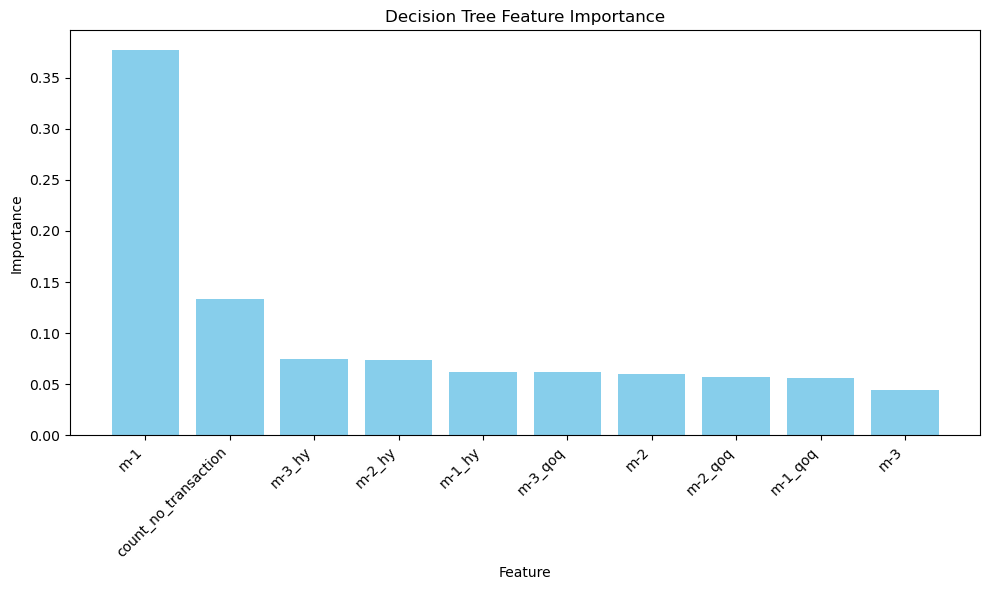

In [757]:
plt.figure(figsize=(10, 6))
plt.bar(
    feature_importance_df["Feature"],
    feature_importance_df["Importance"],
    color="skyblue",
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Decision Tree Feature Importance")
plt.tight_layout()
plt.show()

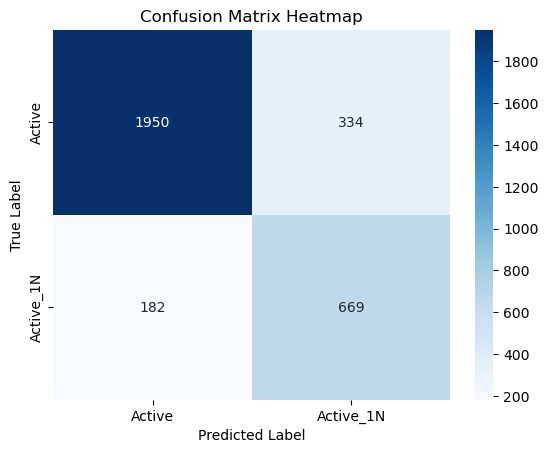

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(conf_matrix, labels):
    #plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Heatmap')
    plt.show()
labels = ['Active', 'Active_1N']
plot_confusion_matrix(confusion_matrix(y_test , y_pred) , labels)


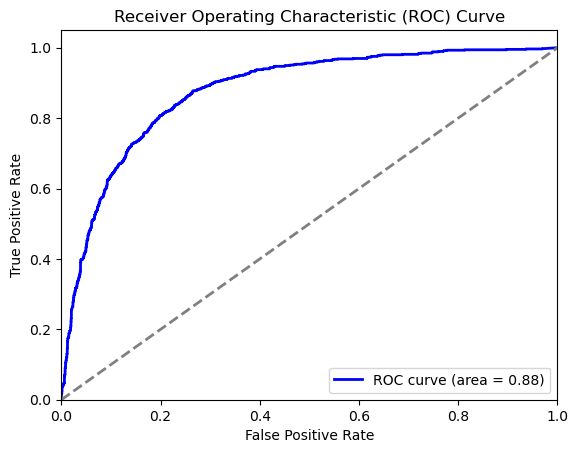

In [116]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
y_pred_probs = lr.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
#plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [117]:
y_pred_probs = lr.predict_proba(X_test)

In [118]:
y_pred_probs[:,0]

array([1.        , 0.11590051, 0.999286  , ..., 0.99948233, 0.99999973,
       0.99928048])

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)

lr = DecisionTreeClassifier()
lr.fit(X_res,y_res)
y_pred = lr.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2026  258]
 [ 415  436]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2284
           1       0.63      0.51      0.56       851

    accuracy                           0.79      3135
   macro avg       0.73      0.70      0.71      3135
weighted avg       0.78      0.79      0.78      3135



In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)

lr = RandomForestClassifier(criterion='log_loss' , n_estimators = 1000)
lr.fit(X_res,y_res)
y_pred = lr.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2118  166]
 [ 304  547]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2284
           1       0.77      0.64      0.70       851

    accuracy                           0.85      3135
   macro avg       0.82      0.79      0.80      3135
weighted avg       0.85      0.85      0.85      3135



In [121]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)
#class_weights = {0: 2.0, 1: 1.2}
lr = SVC(kernel = 'sigmoid' , gamma='scale' )
lr.fit(X_res,y_res)
y_pred = lr.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1714  570]
 [ 203  648]]
              precision    recall  f1-score   support

           0       0.89      0.75      0.82      2284
           1       0.53      0.76      0.63       851

    accuracy                           0.75      3135
   macro avg       0.71      0.76      0.72      3135
weighted avg       0.80      0.75      0.76      3135



#### Model 2

In [122]:
test_1 = test_1.merge(y, left_index=True , right_index=True , how = 'inner')

In [123]:
state_m_df = test_1[test_1['state_m']=='Active_1N']

In [124]:
X = state_m_df[['m-1','m-2','m-3','m-1_hy','m-2_hy','m-3_hy','m-1_qoq','m-2_qoq','m-3_qoq',
          'count_no_transaction' ]]
y_1 = state_m_df[['state_m+1']].replace({'Active':0 , 'Active_2N': 1})

In [125]:
y_1['state_m+1'].value_counts()

1    2295
0     397
Name: state_m+1, dtype: int64

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size=0.33, random_state=42 , stratify=y_1)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)
lr = LogisticRegression()
lr.fit(X_res,y_res)
y_pred = lr.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 86  45]
 [301 457]]
              precision    recall  f1-score   support

           0       0.22      0.66      0.33       131
           1       0.91      0.60      0.73       758

    accuracy                           0.61       889
   macro avg       0.57      0.63      0.53       889
weighted avg       0.81      0.61      0.67       889



In [127]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
lr = SVC(kernel = 'sigmoid' , gamma='scale' )
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)
lr.fit(X_res,y_res)

y_pred = lr.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 76  55]
 [344 414]]
              precision    recall  f1-score   support

           0       0.18      0.58      0.28       131
           1       0.88      0.55      0.67       758

    accuracy                           0.55       889
   macro avg       0.53      0.56      0.48       889
weighted avg       0.78      0.55      0.62       889



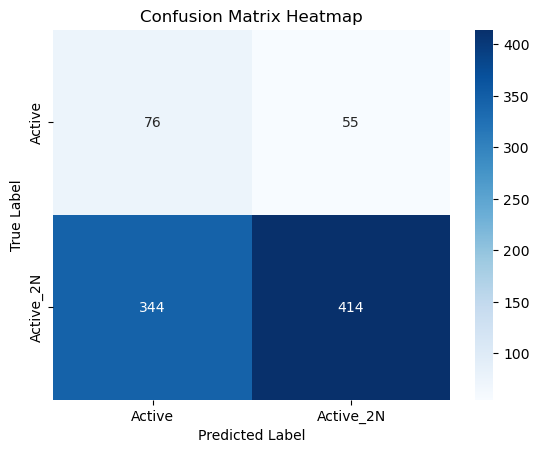

In [128]:
labels = ['Active' , 'Active_2N']
plot_confusion_matrix(confusion_matrix(y_test , y_pred) , labels)

In [129]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
y_pred_probs = lr.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
#plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

AttributeError: predict_proba is not available when  probability=False

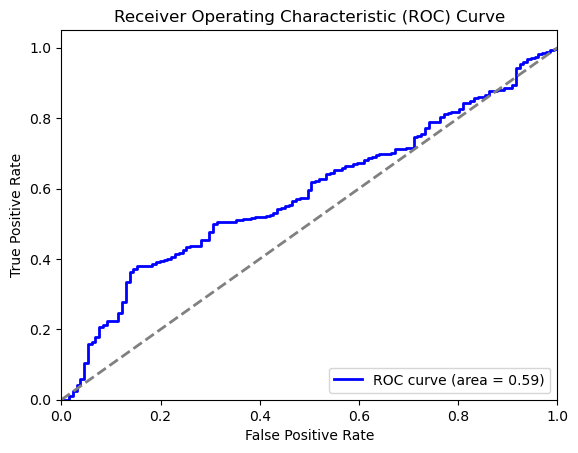

In [130]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
probs_svc = lr.decision_function(X_test)
probs_svc = (probs_svc - probs_svc.min()) / (probs_svc.max() - probs_svc.min())
fpr, tpr, thresholds = roc_curve(y_test, probs_svc)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
#plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [131]:
y_pred_probs = lr.decision_function(X_test)

In [133]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# class svc:
#     def __init__(self):
#         self.model = SVC()
#         self.sampler = RandomOverSampler()
#         self.scaler = StandardScaler()

#     def train_test_split(self, X, y, test_size=0.2, random_state=None):
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
#         return X_train, X_test, y_train, y_test
 
     

#     def train(self, X_train, y_train):
#         X_train_scaled = self.scaler.fit_transform(X_train)
#         self.model.fit(X_train_scaled, y_train)
    

#     def test(self, X_test, y_test):
#         X_test_scaled = self.scaler.fit_transform(X_test)
#         y_pred = self.model.predict(X_test_scaled)
#         classification = classification_report(y_test, y_pred)
#         confusion = confusion_matrix(y_test, y_pred)
#         return classification, confusion, y_pred


# class logisticregressionclassifier:
#     def __init__(self):
#         self.model = LogisticRegression()
#         self.sampler = RandomOverSampler()
#         self.scaler = StandardScaler()

#     def train_test_split(self, X, y, test_size=0.2, random_state=None):
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
#         return X_train, X_test, y_train, y_test
 
     

#     def train(self, X_train, y_train):
#         X_train_scaled = self.scaler.fit_transform(X_train)
#         self.model.fit(X_train_scaled, y_train)
    

#     def test(self, X_test, y_test):
#         X_test_scaled = self.scaler.fit_transform(X_test)
#         y_pred = self.model.predict(X_test_scaled)
#         classification = classification_report(y_test, y_pred)
#         confusion = confusion_matrix(y_test, y_pred)
#         return classification, confusion, y_pred
    
# if __name__ == "__main__":
#     # Generate dummy data using scikit-learn's make_classification
#     X_1= test_1[['m-1','m-2','m-3','m-1_hy','m-2_hy','m-3_hy','m-1_qoq','m-2_qoq','m-3_qoq',
#           'count_no_transaction']]
#     y_1 = y[y.index.isin(X.index)]['state_m'].replace({'Active': 0, 'Active_1N': 1})

#     # Create and train the logistic regression classifier
#     classifier = svc()

#     # Split the data into training and testing sets
#     X_train, X_test, y_train, y_test = classifier.train_test_split(X_1, y_1, test_size=0.32, random_state=42 )
   

#     classifier.train(X_train_scaled, y_train)

#     # Test the classifier
#     accuracy, confusion_matrix, y_pred= classifier.test(X_test, y_test)
#     X_1['state_m'] = test_1['state_m']
#     y_2 = test_1['state_m+1'].replace({'Active': 0, 'Active_1N': 1, 'Active_2N':1})
    
#     classifier_2 = logisticregressionclassifier()
#     classifier_2.train(X_train_scaled, y_train)
#     # accuracy_2 , confusion_matrix_2, y_pred_2 = classifier_2.test(X_test, y_test)
    
#     print("Accuracy:", accuracy)
#     # print("Confusion Matrix:")
#     # print(confusion_matrix_2)



#### Cutoff point

In [5]:
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "SELECT * FROM dalmia_sales.sales_data where billing_date > '2021-04-01' and sold_to_party_code between 7000000 and 7099999"

In [6]:
#reading the data
df = connection_db(host= host , database=database, user=user , password=password, sql_query=sql_query)

In [7]:
df.head()

,month,billing_date,sales_region,sales_zone,sales_type,manufacturing_plant,manufacturing_plant_name,plant,plant_name,sold_to_party_code,...,direct_depot,incoterms_inco,mode_of_transport,t_zone,tzone_desc,brand,product,bill_quantity,gross_bill_price,zbill_invoice_bill
0,Mar'23,2023-03-09,South,TN2,Trade,1301,DCBL FACTORY-DALMIAPURAM,A226,"DCBL,PALANI",7036597,...,Depot,FTP,Road,6246190601,ODDANCHATRAM,DSP,DSP,4.0,36400,34864.0
1,Mar'23,2023-03-09,South,TN2,Trade,1302,DCBL FACTORY-ARIYALUR,A226,"DCBL,PALANI",7036569,...,Depot,FTP,Road,6246140601,CHATRAPATTI,DIP,PPC,2.5,21750,20790.0
2,Mar'23,2023-03-09,South,TN2,Trade,1302,DCBL FACTORY-ARIYALUR,A226,"DCBL,PALANI",7033261,...,Depot,FTP,Road,6246130602,KANAKKANPATTI,DIP,PPC,0.7,6090,5821.2
3,Mar'23,2023-03-09,South,TN2,Trade,1302,DCBL FACTORY-ARIYALUR,A226,"DCBL,PALANI",7033261,...,Depot,FTP,Road,6246130602,KANAKKANPATTI,DIP,PPC,7.3,63510,60706.8
4,Mar'23,2023-03-10,South,TN2,Trade,1302,DCBL FACTORY-ARIYALUR,A226,"DCBL,PALANI",7035467,...,Depot,FTP,Road,6240010602,DINDIGUL,DIP,PPC,9.0,78300,74844.0


In [8]:
from datetime import date

def get_week_number(dt):
    year, week_number, weekday = dt.isocalendar()
    return f"{week_number}_{year}"

df['week_number'] = df['billing_date'].apply(get_week_number)

In [9]:
def return_yoy_df(df):
    df_sales = create_date_columns([df])
    df_sales = df_sales[['sold_to_party_code','week_number','bill_quantity']]
    #df_sales =df_sales[df_sales['sold_to_party_code']!='DONATION']
    df_group_month = df_sales.groupby(['sold_to_party_code','week_number']).agg({'bill_quantity': ['sum']}).reset_index()
    df_group_month.columns = ['Sold To Party Code', 'week_number' , 'Sum']
    pivot_table = pd.pivot_table(df_group_month, values='Sum',columns='week_number', index = 'Sold To Party Code')
    return pivot_table
pivot = return_yoy_df(df)

In [10]:
cols_1 = ['13_2021','14_2021','15_2021','16_2021','17_2021','18_2021','19_2021','20_2021','21_2021','22_2021',
         '23_2021','24_2021','25_2021','26_2021','27_2021','28_2021','29_2021','30_2021','31_2021','32_2021',
         '33_2021','34_2021','35_2021','36_2021','37_2021','38_2021','39_2021','40_2021','41_2021','42_2021',
         '43_2021','44_2021','45_2021','46_2021','47_2021','48_2021','49_2021','50_2021','51_2021','52_2021',
         '1_2022','2_2022','3_2022','4_2022','5_2022','6_2022','7_2022','8_2022','9_2022','10_2022',
          '11_2022','12_2022','13_2022','14_2022','15_2022','16_2022','17_2022','18_2022','19_2022','20_2022',
          '21_2022','22_2022','23_2022','24_2022','25_2022','26_2022','27_2022','28_2022','29_2022','30_2022',
          '31_2022','32_2022','33_2022','34_2022','35_2022','36_2022','37_2022','38_2022','39_2022','40_2022',
          '41_2022','42_2022','43_2022','44_2022','45_2022','46_2022','47_2022','48_2022','49_2022','50_2022',
          '51_2022','52_2022','1_2023','2_2023','3_2023','4_2023','5_2023','6_2023','7_2023','8_2023',
          '9_2023','10_2023','11_2023','12_2023','13_2023','14_2023','15_2023','16_2023','17_2023','18_2023',
          '19_2023','20_2023','21_2023','22_2023','23_2023','24_2023','25_2023','26_2023'
         ]
pivot = pivot[cols_1]

In [167]:
pivot_week = pivot.drop(['14_2023','15_2023','16_2023','17_2023','18_2023',
          '19_2023','20_2023','21_2023','22_2023','23_2023','24_2023','25_2023','26_2023'], axis = 1 )

In [12]:
pivot = pivot.fillna(0)

In [15]:
pivot.to_csv('data/weekly_pivot.csv')

In [171]:
def count_trailing_zeros_before_end_index(df, end_index):
    counts = []
    for row in df.itertuples(index=False):
        count = 0
        for i in range(end_index - 1, -1, -1):
            if row[i] == 0:
                count += 1
            else:
                break
        counts.append(count)
    return counts

result_matrix_week = pd.DataFrame(index = dealer_sales.index)
for i in range(len(pivot_week.columns)):
    string = str(i)
    result_matrix_week[string] = count_trailing_zeros_before_end_index(pivot_week, i)
result_matrix_week.drop('0', axis = 1 , inplace = True)

In [177]:
#Status of each dealer 
def inactive(value):
    if value == 0: 
        return 'Active'
    elif value == 1: 
        return 'Active_1N'
    elif value == 2: 
        return 'Active_2N'
    elif value == 3: 
        return 'Active_3N'
    elif value > 3 and value <=12:
        return 'Inactive'
    else: 
        return 'Churn'
    
for i in result_matrix_week.columns:
    result_matrix_week[i] = result_matrix_week[i].apply(inactive)

TypeError: '>' not supported between instances of 'str' and 'int'

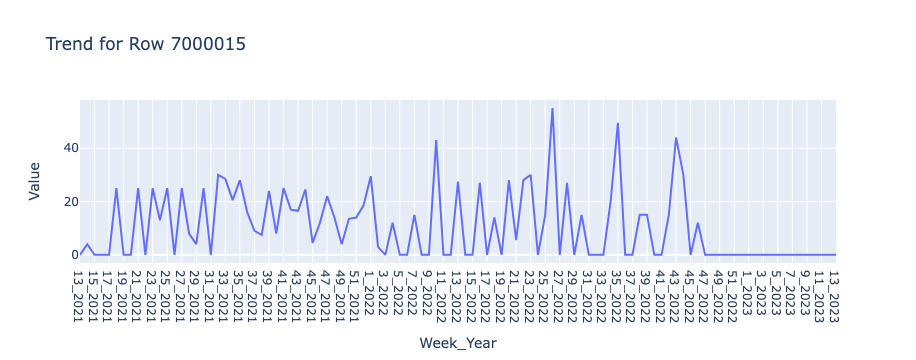

Dropdown(description='Select Row:', options=(7000004, 7000010, 7000015, 7000019, 7000022, 7000025, 7000027, 70…

In [179]:
#%matplotlib widget
import plotly.express as px
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display

# Assuming your DataFrame is named 'df'


# Create a dropdown widget with row numbers
dropdown = widgets.Dropdown(
    options=pivot_week.index,
    description='Select Row:'
)

# Define the function to update the plot when the dropdown value changes
def on_dropdown_change(change):
    row = change.new
    plot_trend(row)

dropdown.observe(on_dropdown_change, names='value')

# Define the plot function
def plot_trend(row):
    row_data = pivot_week.loc[row]
    data = {'Week_Year': row_data.index, 'Value': row_data.values}
    fig = px.line(data, x='Week_Year', y='Value', title=f'Trend for Row {row}')
    fig.show()

# Initial plot with the first row
plot_trend(pivot_week.index[2])


# Display the dropdown widget
display(dropdown)

In [180]:
result_matrix_week

,1,2,3,4,5,6,7,8,9,10,...,95,96,97,98,99,100,101,102,103,104
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active_1N,Active,Active,Active,Active,Active,Active,Active_1N,Active
7000010,Active_1N,Active,Active_1N,Active_2N,Active,Active_1N,Active,Active,Active_1N,Active_2N,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn
7000015,Active_1N,Active,Active_1N,Active_2N,Active_3N,Active,Active_1N,Active_2N,Active,Active_1N,...,Inactive,Inactive,Inactive,Inactive,Churn,Churn,Churn,Churn,Churn,Churn
7000019,Active_1N,Active_2N,Active_3N,Inactive,Active,Active_1N,Active_2N,Active,Active_1N,Active,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn
7000022,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Inactive,Active,Active,Active_1N,Active_2N,Active_3N,Inactive,Active,Active_1N,Active_2N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041150,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn
7041151,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn
7041160,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn


In [181]:
pivot_week = pivot_week.merge(result_matrix_week['104'] , left_index=True , right_index=True , how = 'inner')
pivot_week_churn = pivot_week[pivot_week['104'].isin(['Churn','Inactive'])]
pivot_week_churn = pivot_week_churn.drop('104' , axis = 1)
pivot_test_churn = pd.DataFrame()
i = 0
while i < len(pivot_week.columns)-2:
    pivot_test_churn[i] = pivot_week_churn[pivot_week_churn.columns[i]]+pivot_week_churn[pivot_week_churn.columns[i+1]]
    i = i+2
    

In [182]:
pivot_week['104'].value_counts()

Active       6872
Churn        5551
Active_1N    1470
Inactive     1156
Active_2N     575
Active_3N     402
Name: 104, dtype: int64

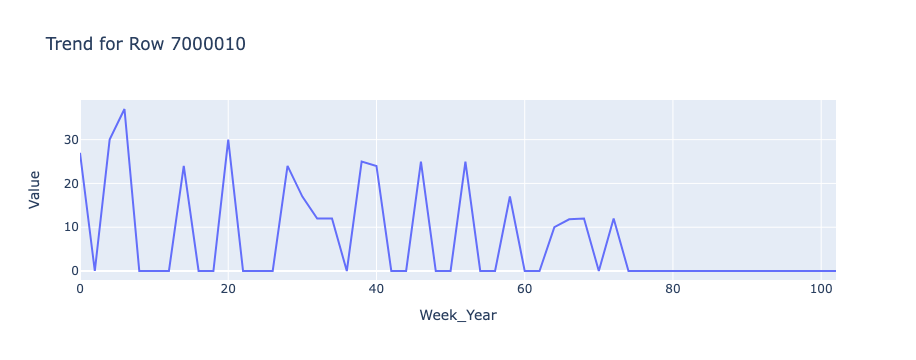

Dropdown(description='Select Row:', options=(7000010, 7000015, 7000019, 7000039, 7000043, 7000044, 7000048, 70…

In [183]:
#%matplotlib widget
import plotly.express as px
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display

#dataframe name is 


# Create a dropdown widget with row numbers
dropdown = widgets.Dropdown(
    options=pivot_test_churn.index,
    description='Select Row:'
)

# Define the function to update the plot when the dropdown value changes
def on_dropdown_change(change):
    row = change.new
    plot_trend(row)

dropdown.observe(on_dropdown_change, names='value')

# Define the plot function
def plot_trend(row):
    row_data = pivot_test_churn.loc[row]
    
    data = {'Week_Year': row_data.index, 'Value': row_data.values}
    fig = px.line(data, x='Week_Year', y='Value', title=f'Trend for Row {row}')
    fig.show()

# Initial plot with the first row
plot_trend(pivot_test_churn.index[0])


# Display the dropdown widget
display(dropdown)


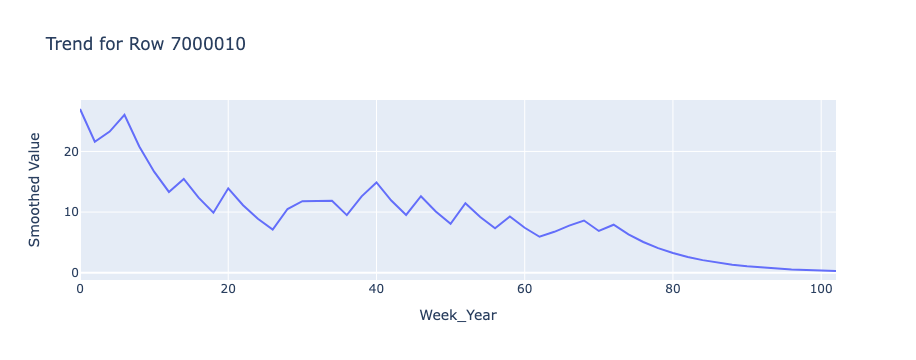

Dropdown(description='Select Row:', options=(7000010, 7000015, 7000019, 7000039, 7000043, 7000044, 7000048, 70…

In [184]:
import numpy as np
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Assuming your DataFrame is named 'pivot_test_churn'

# Apply exponential smoothing to a given time series data
def exponential_smoothing(data, alpha):
    smoothed_data = [data.iloc[0]]  # Initialize with the first data point
    for i in range(1, len(data)):
        smoothed_value = alpha * data.iloc[i] + (1 - alpha) * smoothed_data[-1]
        smoothed_data.append(smoothed_value)
    return smoothed_data

# Create a dropdown widget with row numbers
dropdown = widgets.Dropdown(
    options=pivot_test_churn.index,
    description='Select Row:'
)

# Define the function to update the plot when the dropdown value changes
def on_dropdown_change(change):
    row = change.new
    plot_trend(row)

dropdown.observe(on_dropdown_change, names='value')

# Define the plot function with exponential smoothing
def plot_trend(row):
    row_data = pivot_test_churn.loc[row]

    # Apply exponential smoothing to the row data
    alpha = 0.2  # Adjust alpha based on the desired smoothing level (0 < alpha < 1)
    smoothed_row_data = exponential_smoothing(row_data, alpha)

    data = {
        'Week_Year': row_data.index,
        'Value': row_data.values,
        'Smoothed Value': smoothed_row_data
    }
    fig = px.line(data, x='Week_Year', y='Smoothed Value', title=f'Trend for Row {row}')
    fig.show()

# Initial plot with the first row
plot_trend(pivot_test_churn.index[0])

# Display the dropdown widget
display(dropdown)

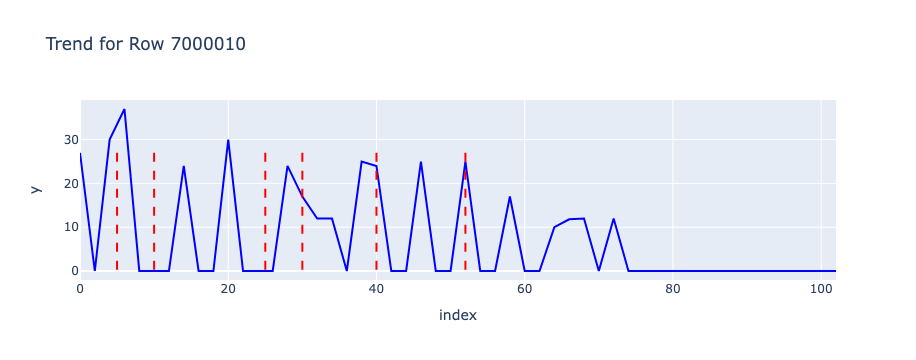

Dropdown(description='Select Row:', options=(7000010, 7000015, 7000019, 7000039, 7000043, 7000044, 7000048, 70…

In [185]:
import numpy as np
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import ruptures as rpt

# Assuming your DataFrame is named 'pivot_test_churn'

# Apply exponential smoothing to a given time series data
def exponential_smoothing(data, alpha):
    smoothed_data = [data.iloc[0]]  # Initialize with the first data point
    for i in range(1, len(data)):
        smoothed_value = alpha * data.iloc[i] + (1 - alpha) * smoothed_data[-1]
        smoothed_data.append(smoothed_value)
    return smoothed_data

# Detect critical points in a time series using ruptures
def detect_critical_points(data):
    # Convert data to a numpy array
    values = data.values.reshape(-1, 1)  # Reshape to 2D array

    # Create a change point detection model using the Pelt algorithm
    model = rpt.Pelt(model="l2").fit(values)

    # Find the change points (critical points)
    change_points = model.predict(pen=10) 
    
    # Convert the critical points back to timestamps
    #timestamps = data.index[change_points].tolist()
    return change_points

# Create a dropdown widget with row numbers
dropdown = widgets.Dropdown(
    options=pivot_test_churn.index,
    description='Select Row:'
)

# Define the function to update the plot when the dropdown value changes
def on_dropdown_change(change):
    row = change.new
    plot_trend(row)

dropdown.observe(on_dropdown_change, names='value')

# Define the plot function with exponential smoothing and critical point detection
def plot_trend(row):
    row_data = pivot_test_churn.loc[row]

    # Apply exponential smoothing to the row data
    alpha = 0.2  # Adjust alpha based on the desired smoothing level (0 < alpha < 1)
    smoothed_row_data = exponential_smoothing(row_data, alpha)

    # Convert smoothed data to a DataFrame
    smoothed_data_df = pd.DataFrame({'Smoothed Value': smoothed_row_data}, index=row_data.index)

    # Detect critical points in the smoothed data
    critical_points = detect_critical_points(smoothed_data_df)

    # Plot the smoothed data
    fig = px.line(row_data, x=row_data.index, y=row_data.values, title=f'Trend for Row {row}')
    fig.update_traces(line=dict(color='blue'))

    # Plot critical points on the smoothed data plot
    for cp in critical_points:
        fig.add_shape(
            type="line",
            x0=cp,
            y0=min(smoothed_row_data),
            x1=cp,
            y1=max(smoothed_row_data),
            line=dict(color='red', width=2, dash='dash')
        )

    fig.show()

# Initial plot with the first row
plot_trend(pivot_test_churn.index[0])

# Display the dropdown widget
display(dropdown)



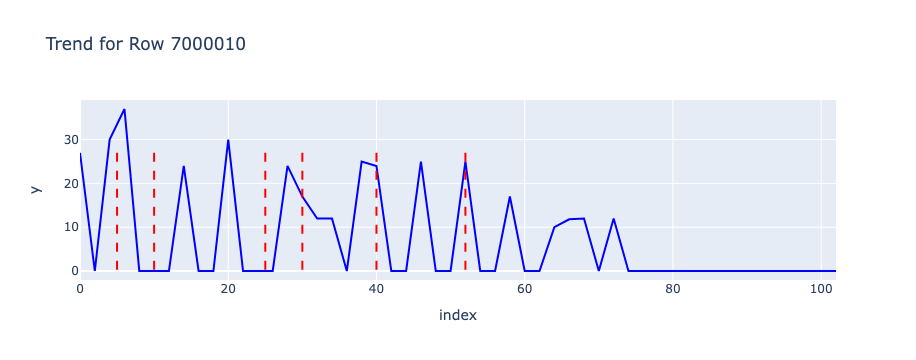

Dropdown(description='Select Row:', index=2, options=(7000010, 7000015, 7000019, 7000039, 7000043, 7000044, 70…

In [200]:
def detect_critical_points(data):
    # Convert data to a numpy array
    values = data.values.reshape(-1, 1)  # Reshape to 2D array

    # Create a change point detection model using Binary Segmentation
    model = "rbf"
    algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(data)
    my_bkps = algo.predict(n_bkps=5)  # 'n_bkps' limits the number of change points to 5

    # Convert the critical points back to timestamps
    #timestamps = data.index[change_points].tolist()
    return my_bkps

def plot_trend(row):
    row_data = pivot_test_churn.loc[row]

    # Apply exponential smoothing to the row data
    alpha = 0.2  # Adjust alpha based on the desired smoothing level (0 < alpha < 1)
    smoothed_row_data = exponential_smoothing(row_data, alpha)

    # Convert smoothed data to a DataFrame
    smoothed_data_df = pd.DataFrame({'Smoothed Value': smoothed_row_data}, index=row_data.index)

    # Detect critical points in the smoothed data
    critical_points = detect_critical_points(smoothed_data_df)

    # Plot the smoothed data
    fig = px.line(row_data, x=row_data.index, y=row_data.values, title=f'Trend for Row {row}')
    fig.update_traces(line=dict(color='blue'))

    # Plot critical points on the smoothed data plot
    for cp in critical_points:
        fig.add_shape(
            type="line",
            x0=cp,
            y0=min(smoothed_row_data),
            x1=cp,
            y1=max(smoothed_row_data),
            line=dict(color='red', width=2, dash='dash')
        )

    fig.show()

# Initial plot with the first row
plot_trend(pivot_test_churn.index[0])
display(dropdown)

In [190]:
import numpy as np
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

# Generate dummy time series data with a sine wave pattern and noise
def generate_dummy_data():
    time_steps = np.arange(0, 20, 0.1)
    data = np.sin(time_steps) + np.random.normal(scale=0.2, size=len(time_steps))
    return data

data = generate_dummy_data()

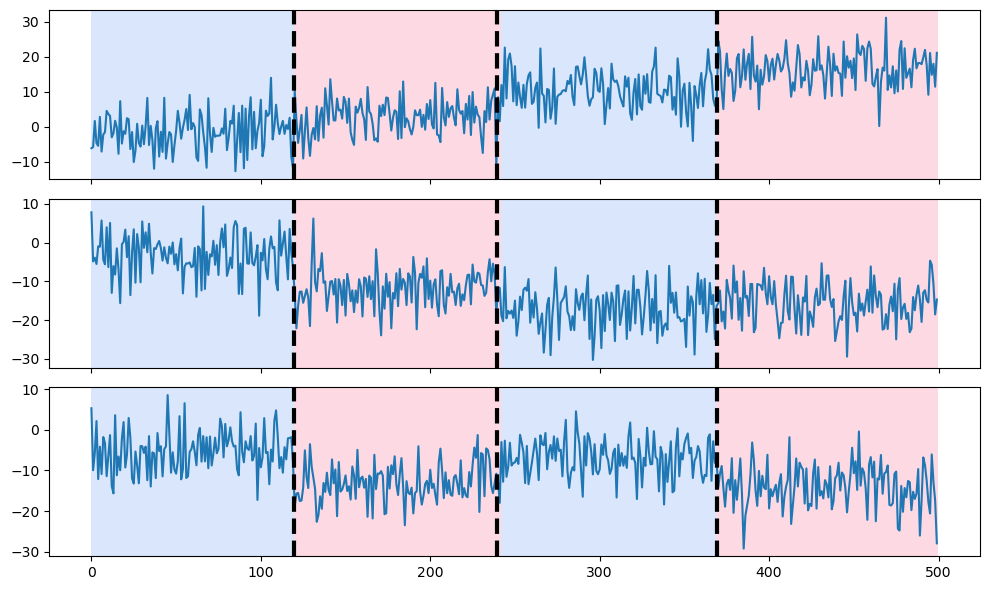

In [197]:
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt

# creation of data
n, dim = 500, 3
n_bkps, sigma = 3, 5
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(signal)
my_bkps = algo.predict(n_bkps=3)

# show results
rpt.show.display(signal, bkps, my_bkps, figsize=(10, 6))
plt.show()

In [202]:
row = pivot_test_churn.loc[7000010]

In [205]:
maxi = row.max()
maxi

37.0

In [207]:
list_i = []
for i in range(len(row.values)-1):
    a = row.values[i+1]-row.values[i]
    list_i.append(a)
    

In [212]:
for i in range(len(list_i)): 
    list_i[i] = list_i[i]/maxi

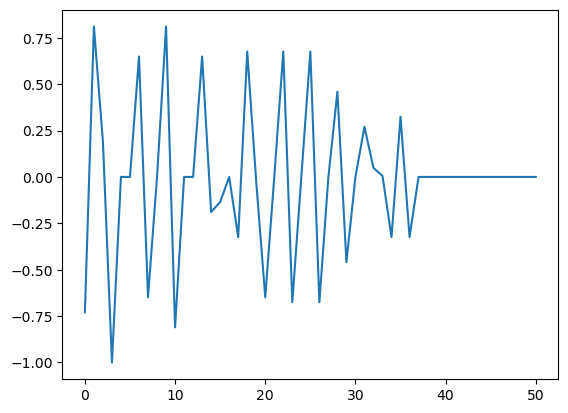

In [217]:
plt.plot(list_i)
#fig = px.line(x=list_i.index, y=list_i, title=f'Trend for Row {row}')
#fig.update_traces(line=dict(color='blue'))

# Plot critical points on the smoothed data plot
# for cp in critical_points:
#     fig.add_shape(
#         type="line",
#         x0=cp,
#         y0=min(smoothed_row_data),
#         x1=cp,
#         y1=max(smoothed_row_data),
#         line=dict(color='red', width=2, dash='dash')
#     )

# fig.show()

In [219]:
list_i.index(min(list_i))-1

2

In [295]:
df_train = pd.read_csv('data/training_data.csv')
df_train.index = df_train['Sold To Party Code']
df_train.drop('Sold To Party Code', axis=1, inplace=True)

In [296]:
df_train

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1
Sold To Party Code,,,,,,,,,,,,
7000004,14.0,13.0,4.0,2.0,1.0,2.0,1.0,1.0,8.0,8.0,5.0,9.0
7000010,0.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0
7000015,7.0,5.0,1.0,7.0,4.0,8.0,10.0,5.0,5.0,5.0,7.0,3.0
7000022,0.0,1.0,2.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,0.0,2.0
7000025,4.0,5.0,8.0,7.0,3.0,4.0,4.0,8.0,5.0,12.0,6.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,6.0,17.0,17.0,17.0,12.0,26.0,28.0,28.0,19.0,21.0,30.0
7036499,0.0,3.0,20.0,7.0,2.0,7.0,8.0,9.0,4.0,3.0,10.0,11.0
7036501,0.0,10.0,7.0,2.0,2.0,6.0,3.0,8.0,4.0,37.0,23.0,55.0


In [297]:
idx = list(df_train.index)

In [298]:
row = df_train.loc[7000015]
maxi = row.max()
list_i = [0]
for i in range(len(row.values)-1):
    a = row.values[i+1]-row.values[i]
    list_i.append(a)
for i in range(len(list_i)): 
    list_i[i] = list_i[i]/maxi




In [299]:
min_i = list_i.index(min(list_i))
list_i.remove(max(list_i))

# Get the index of the second-highest element
min_2i = list_i.index(max(list_i))



def index_i(x):
    if x ==0:
        cp = 'm-12'
    if x==1:
        cp = 'm-12'
    if x ==2:
        cp = 'm-11'
    if x==3:
        cp = 'm-10'
    if x ==4:
        cp = 'm-9'
    if x==5:
        cp = 'm-8'
    if x ==6:
        cp = 'm-7'
    if x==7:
        cp = 'm-6'
    if x==8:
        cp = 'm-5'
    if x ==9:
        cp = 'm-4'
    if x==10:
        cp = 'm-3'
    if x ==11:
        cp = 'm-2'
    return cp
min_id = index_i(min_i)
min_2id = index_i(min_2i)
#max_id = index_i(max_i)

In [300]:
df_train.head(10)

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1
Sold To Party Code,,,,,,,,,,,,
7000004,14.0,13.0,4.0,2.0,1.0,2.0,1.0,1.0,8.0,8.0,5.0,9.0
7000010,0.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0
7000015,7.0,5.0,1.0,7.0,4.0,8.0,10.0,5.0,5.0,5.0,7.0,3.0
7000022,0.0,1.0,2.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,0.0,2.0
7000025,4.0,5.0,8.0,7.0,3.0,4.0,4.0,8.0,5.0,12.0,6.0,10.0
7000027,21.0,35.0,71.0,16.0,31.0,1.0,10.0,14.0,5.0,4.0,2.0,9.0
7000029,3.0,2.0,5.0,1.0,3.0,3.0,3.0,5.0,5.0,3.0,3.0,8.0
7000032,22.0,21.0,20.0,20.0,20.0,18.0,21.0,21.0,21.0,28.0,30.0,49.0
7000037,43.0,29.0,91.0,39.0,88.0,75.0,110.0,173.0,229.0,144.0,160.0,164.0


In [301]:
df_train_1 = df_train[df_train.index.isin(pivot_test_churn.index)]

NameError: name 'pivot_test_churn' is not defined

In [302]:
for i in df_train_1.head(10).index:
    row = df_train_1.loc[i]
    maxi = row.max()
    list_i = [0]
    for i in range(len(row.values)-1):
        a = row.values[i+1]-row.values[i]
        list_i.append(a)
    for i in range(len(list_i)): 
        list_i[i] = list_i[i]/maxi
    min_i = list_i.index(min(list_i))
    list_i.remove(max(list_i))

    # Get the index of the second-highest element
    min_2i = list_i.index(max(list_i))
    min_id = index_i(min_i)
    min_2id = index_i(min_2i)

    plt.plot(row)
    plt.axvline(min_id, color='red', linestyle='dashed', label='min_inflection')
    #plt.axvline(min_2id, color='green', linestyle='dashed', label='max_inflection')
    plt.xlabel('Months')
    plt.ylabel('Sales_Quantity')
    plt.title('Inflection_point')
    plt.show()

NameError: name 'df_train_1' is not defined

In [303]:
df_train

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1
Sold To Party Code,,,,,,,,,,,,
7000004,14.0,13.0,4.0,2.0,1.0,2.0,1.0,1.0,8.0,8.0,5.0,9.0
7000010,0.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0
7000015,7.0,5.0,1.0,7.0,4.0,8.0,10.0,5.0,5.0,5.0,7.0,3.0
7000022,0.0,1.0,2.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,0.0,2.0
7000025,4.0,5.0,8.0,7.0,3.0,4.0,4.0,8.0,5.0,12.0,6.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,6.0,17.0,17.0,17.0,12.0,26.0,28.0,28.0,19.0,21.0,30.0
7036499,0.0,3.0,20.0,7.0,2.0,7.0,8.0,9.0,4.0,3.0,10.0,11.0
7036501,0.0,10.0,7.0,2.0,2.0,6.0,3.0,8.0,4.0,37.0,23.0,55.0


In [304]:
df_train_2 = df_train[df_train.index.isin(pivot_test_churn.index)==False]
for g in df_train_2.head(1).index:
    row = df_train_2.loc[g]
    maxi = row.max()
    list_i = [0]
    for i in range(len(row.values)-1):
        a = row.values[i+1]-row.values[i]
        list_i.append(a)
    for i in range(len(list_i)): 
        list_i[i] = list_i[i]/maxi
    min_i = list_i.index(min(list_i))
    list_i.remove(max(list_i))

    # Get the index of the second-highest element
    min_2i = list_i.index(max(list_i))
    min_id = index_i(min_i)
    min_2id = index_i(min_2i)

    plt.plot(row)
    plt.axvline(min_id, color='red', linestyle='dashed', label='min_inflection')
    #plt.axvline(min_2id, color='green', linestyle='dashed', label='max_inflection')
    plt.xlabel('Months')
    plt.ylabel('Sales_Quantity')
    plt.title(g)
    plt.show()

NameError: name 'pivot_test_churn' is not defined

Top 2 Trends:
Sold To Party Code
7000037    11.000000
7000032     2.454545
dtype: float64


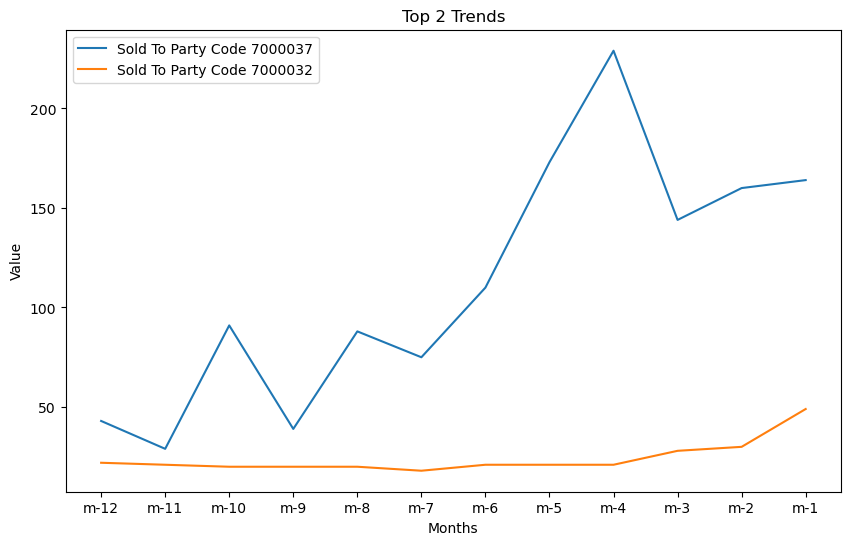

In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data
data = {
    'Sold To Party Code': [7000004, 7000010, 7000015, 7000022, 7000025, 7000027, 7000029, 7000032, 7000037, 7000040],
    'm-12': [14.0, 0.0, 7.0, 0.0, 4.0, 21.0, 3.0, 22.0, 43.0, 0.0],
    'm-11': [13.0, 3.0, 5.0, 1.0, 5.0, 35.0, 2.0, 21.0, 29.0, 0.0],
    'm-10': [4.0, 2.0, 1.0, 2.0, 8.0, 71.0, 5.0, 20.0, 91.0, 0.0],
    'm-9': [2.0, 1.0, 7.0, 2.0, 7.0, 16.0, 1.0, 20.0, 39.0, 0.0],
    'm-8': [1.0, 2.0, 4.0, 2.0, 3.0, 31.0, 3.0, 20.0, 88.0, 0.0],
    'm-7': [2.0, 1.0, 8.0, 3.0, 4.0, 1.0, 3.0, 18.0, 75.0, 0.0],
    'm-6': [1.0, 0.0, 10.0, 3.0, 4.0, 10.0, 3.0, 21.0, 110.0, 0.0],
    'm-5': [1.0, 1.0, 5.0, 1.0, 8.0, 14.0, 5.0, 21.0, 173.0, 8.0],
    'm-4': [8.0, 1.0, 5.0, 2.0, 5.0, 5.0, 5.0, 21.0, 229.0, 7.0],
    'm-3': [8.0, 0.0, 7.0, 2.0, 12.0, 4.0, 3.0, 28.0, 144.0, 13.0],
    'm-2': [5.0, 3.0, 3.0, 0.0, 6.0, 2.0, 3.0, 30.0, 160.0, 2.0],
    'm-1': [9.0, 1.0, 3.0, 2.0, 10.0, 9.0, 8.0, 49.0, 164.0, 7.0]
}

# Create a DataFrame from the sample data
df = pd.DataFrame(data)

# Set the 'Sold To Party Code' column as the index
df.set_index('Sold To Party Code', inplace=True)

# Transpose the DataFrame to get time series for each Sold To Party Code
df_transposed = df.T

# Calculate the slopes for each Sold To Party Code
slopes = df_transposed.diff().mean()

# Sort the slopes in descending order
top_2_trends = slopes.sort_values(ascending=False).head(2)

# Get the Sold To Party Codes with the top 2 trends
top_2_codes = top_2_trends.index

print("Top 2 Trends:")
print(top_2_trends)

# Plot the top 2 trends
plt.figure(figsize=(10, 6))
for column in top_2_codes:
    plt.plot(df_transposed.index, df_transposed[column], label=f'Sold To Party Code {column}')

plt.xlabel('Months')
plt.ylabel('Value')
plt.title('Top 2 Trends')
plt.legend()
plt.show()



In [306]:
df_train['month_new_dealer'] = df_train.apply(count_zeros_before_first_nonzero , axis = 1)

In [307]:
df_train = df_train[df_train['month_new_dealer']<=4]

In [308]:
df_train = df_train.merge(y , left_index=True , right_index=True , how = 'inner')

In [309]:
result_matrix_1['24'].value_counts()

Active       7529
Inactive     1714
Active_1N     402
Active_3N     195
Active_2N     174
Name: 24, dtype: int64

In [310]:
df_train = df_train.merge(result_matrix_1['24'] , left_index=True , right_index=True , how = 'inner')
churn_df = df_train[df_train['24'].isin(['Churn','Inactive'])]

In [311]:
churn_df = churn_df[['m-12', 'm-11', 'm-10', 'm-9', 'm-8', 'm-7', 'm-6', 'm-5', 'm-4', 'm-3',
       'm-2', 'm-1']]

In [312]:
def plot_trend(row):
    row_data = churn_df.loc[row]

    # Apply exponential smoothing to the row data
    alpha = 0.2  # Adjust alpha based on the desired smoothing level (0 < alpha < 1)
    smoothed_row_data = exponential_smoothing(row_data, alpha)

    # Convert smoothed data to a DataFrame
    smoothed_data_df = pd.DataFrame({'Smoothed Value': smoothed_row_data}, index=row_data.index)

    # Detect critical points in the smoothed data
    critical_points = detect_critical_points(smoothed_data_df)

    # Plot the original data
    fig = px.line(row_data, x=row_data.index, y=row_data.values , title=f'Trend for Row {row}')
    fig.update_traces(line=dict(color='blue'), name='Original Data')

    # Plot the smoothed data
    fig.add_trace(px.line(smoothed_data_df, x=smoothed_data_df.index, y='Smoothed Value').data[0])
    fig.update_traces(line=dict(color='red'), name='Smoothed Data')

    # Plot critical points on the smoothed data plot
    for cp in critical_points:
        fig.add_shape(
            type="line",
            x0=smoothed_data_df.index[cp],
            y0=min(smoothed_row_data),
            x1=smoothed_data_df.index[cp],
            y1=max(smoothed_row_data),
            line=dict(color='red', width=2, dash='dash')
        )

    fig.show()

# Initial plot with the first row
plot_trend(churn_df.index[0])

# Display the dropdown widget
display(dropdown)


IndexError: index 12 is out of bounds for axis 0 with size 12

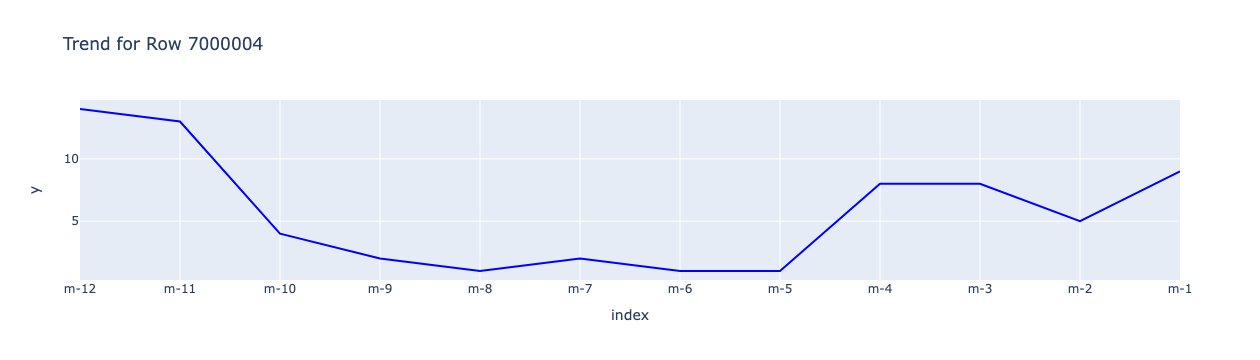

Dropdown(description='Select Row:', options=(7000004, 7000010, 7000015, 7000022, 7000025, 7000027, 7000029, 70…

In [352]:
df_train_3 = df_train[['m-12', 'm-11', 'm-10', 'm-9', 'm-8', 'm-7', 'm-6', 'm-5', 'm-4', 'm-3',
       'm-2', 'm-1']]
import numpy as np
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import ruptures as rpt

# Assuming your DataFrame is named 'pivot_test_churn'

# Apply exponential smoothing to a given time series data
def exponential_smoothing(data, alpha):
    smoothed_data = [data.iloc[0]]  # Initialize with the first data point
    for i in range(1, len(data)):
        smoothed_value = alpha * data.iloc[i] + (1 - alpha) * smoothed_data[-1]
        smoothed_data.append(smoothed_value)
    return smoothed_data

# Detect critical points in a time series using ruptures
def detect_critical_points(data):
    # Convert data to a numpy array
    values = data.values.reshape(-1, 1)  # Reshape to 2D array

    # Create a change point detection model using the Pelt algorithm
    model = rpt.Pelt(model="l2").fit(values)

    # Find the change points (critical points)
    change_points = model.predict(pen=10) 
    
    # Convert the critical points back to timestamps
    #timestamps = data.index[change_points].tolist()
    return change_points

# Create a dropdown widget with row numbers
dropdown = widgets.Dropdown(
    options=df_train_3.index,
    description='Select Row:'
)

# Define the function to update the plot when the dropdown value changes
def on_dropdown_change(change):
    row = change.new
    plot_trend(row)

dropdown.observe(on_dropdown_change, names='value')

# Define the plot function with exponential smoothing and critical point detection
def plot_trend(row):
    row_data = df_train_3.loc[row]

    # Apply exponential smoothing to the row data
    alpha = 0.2  # Adjust alpha based on the desired smoothing level (0 < alpha < 1)
    smoothed_row_data = exponential_smoothing(row_data, alpha)

    # Convert smoothed data to a DataFrame
    smoothed_data_df = pd.DataFrame({'Smoothed Value': smoothed_row_data}, index=row_data.index)
    fig = px.line(row_data, x=row_data.index, y=row_data.values , title=f'Trend for Row {row}')
    fig.update_traces(line=dict(color='blue'), name='Original Data')

    # Plot the smoothed data
    fig.add_trace(px.line(smoothed_data_df, x=smoothed_data_df.index, y='Smoothed Value').data[0])
    fig.update_traces(line=dict(color='red'), name='Smoothed Data')

    # Detect critical points in the smoothed data
    critical_points = detect_critical_points(smoothed_data_df)

    # Plot the smoothed data
    fig = px.line(row_data, x=row_data.index, y=row_data.values , title=f'Trend for Row {row}')
    fig.update_traces(line=dict(color='blue'))
    


    fig.show()

# Initial plot with the first row
plot_trend(df_train_3.index[0])

# Display the dropdown widget
display(dropdown)

In [314]:
churn_df['L1'] = churn_df[['m-12', 'm-11', 'm-10', 'm-9', 'm-8', 'm-7']].sum(axis =1 )/6
churn_df['L2'] = churn_df[['m-6', 'm-5', 'm-4', 'm-3','m-2', 'm-1']].sum(axis =1)/6

In [315]:
churn_df.columns

Index(['m-12', 'm-11', 'm-10', 'm-9', 'm-8', 'm-7', 'm-6', 'm-5', 'm-4', 'm-3',
       'm-2', 'm-1', 'L1', 'L2'],
      dtype='object')

In [316]:
churn_df

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,L1,L2
Sold To Party Code,,,,,,,,,,,,,,
7000010,0.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0,1.500000,1.000000
7000015,7.0,5.0,1.0,7.0,4.0,8.0,10.0,5.0,5.0,5.0,7.0,3.0,5.333333,5.833333
7000050,3.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,1.666667,0.833333
7000073,3.0,2.0,4.0,3.0,4.0,1.0,0.0,3.0,2.0,2.0,2.0,2.0,2.833333,1.833333
7000084,12.0,3.0,3.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,0.0,1.0,4.333333,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036133,0.0,0.0,0.0,0.0,14.0,6.0,13.0,2.0,0.0,0.0,0.0,1.0,3.333333,2.666667
7036138,0.0,0.0,0.0,0.0,2.0,4.0,7.0,10.0,4.0,6.0,5.0,5.0,1.000000,6.166667
7036156,0.0,0.0,0.0,0.0,31.0,76.0,74.0,43.0,6.0,6.0,1.0,2.0,17.833333,22.000000


In [317]:
churn_df['q1_avg'] = churn_df[['m-12', 'm-11', 'm-10']].sum(axis =1 )
churn_df['q2_avg'] = churn_df[['m-9', 'm-8', 'm-7']].sum(axis =1 )
churn_df['q3_avg'] = churn_df[['m-6', 'm-5', 'm-4']].sum(axis =1 )
churn_df['q4_avg'] = churn_df[['m-3', 'm-2', 'm-1']].sum(axis =1 )

In [318]:
churn_df

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,L1,L2,q1_avg,q2_avg,q3_avg,q4_avg
Sold To Party Code,,,,,,,,,,,,,,,,,,
7000010,0.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0,1.500000,1.000000,5.0,4.0,2.0,4.0
7000015,7.0,5.0,1.0,7.0,4.0,8.0,10.0,5.0,5.0,5.0,7.0,3.0,5.333333,5.833333,13.0,19.0,20.0,15.0
7000050,3.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,1.666667,0.833333,6.0,4.0,4.0,1.0
7000073,3.0,2.0,4.0,3.0,4.0,1.0,0.0,3.0,2.0,2.0,2.0,2.0,2.833333,1.833333,9.0,8.0,5.0,6.0
7000084,12.0,3.0,3.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,0.0,1.0,4.333333,1.666667,18.0,8.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036133,0.0,0.0,0.0,0.0,14.0,6.0,13.0,2.0,0.0,0.0,0.0,1.0,3.333333,2.666667,0.0,20.0,15.0,1.0
7036138,0.0,0.0,0.0,0.0,2.0,4.0,7.0,10.0,4.0,6.0,5.0,5.0,1.000000,6.166667,0.0,6.0,21.0,16.0
7036156,0.0,0.0,0.0,0.0,31.0,76.0,74.0,43.0,6.0,6.0,1.0,2.0,17.833333,22.000000,0.0,107.0,123.0,9.0


In [319]:
churn_df['change_l']=(churn_df['L2']-churn_df['L1'])/churn_df['L1']

In [454]:
churn_df['change_q2']=((churn_df['m-1']-churn_df['m-2'])/churn_df['m-2']+ (churn_df['m-2']-churn_df['m-3'])/churn_df['m-3'])/2
churn_df['change_q3']=(churn_df['q4_avg']-churn_df['q3_avg'])/churn_df['q3_avg']

In [456]:
churn_df = churn_df.replace([np.nan, np.inf, -np.inf], 0)

In [457]:
churn_df

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,...,L2,q1_avg,q2_avg,q3_avg,q4_avg,change_l,change_q2,change_q3,cluster,total
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000010,0.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,...,1.000000,5.0,4.0,2.0,4.0,-0.333333,0.000000,1.000000,7,15.0
7000015,7.0,5.0,1.0,7.0,4.0,8.0,10.0,5.0,5.0,5.0,...,5.833333,13.0,19.0,20.0,15.0,0.093750,-0.085714,-0.250000,11,67.0
7000050,3.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,...,0.833333,6.0,4.0,4.0,1.0,-0.500000,0.000000,-0.750000,5,15.0
7000073,3.0,2.0,4.0,3.0,4.0,1.0,0.0,3.0,2.0,2.0,...,1.833333,9.0,8.0,5.0,6.0,-0.352941,0.000000,0.200000,6,28.0
7000084,12.0,3.0,3.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,...,1.666667,18.0,8.0,6.0,4.0,-0.615385,0.000000,-0.333333,1,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036133,0.0,0.0,0.0,0.0,14.0,6.0,13.0,2.0,0.0,0.0,...,2.666667,0.0,20.0,15.0,1.0,-0.200000,0.000000,-0.933333,5,36.0
7036138,0.0,0.0,0.0,0.0,2.0,4.0,7.0,10.0,4.0,6.0,...,6.166667,0.0,6.0,21.0,16.0,5.166667,-0.083333,-0.238095,24,43.0
7036156,0.0,0.0,0.0,0.0,31.0,76.0,74.0,43.0,6.0,6.0,...,22.000000,0.0,107.0,123.0,9.0,0.233645,0.083333,-0.926829,15,239.0


In [623]:
churn_df_1 = churn_df[['change_l','change_q2']]
churn_df_1

,change_l,change_q2
Sold To Party Code,,
7000010,-0.333333,0.000000
7000015,0.093750,-0.085714
7000050,-0.500000,0.000000
7000073,-0.352941,0.000000
7000084,-0.615385,0.000000
...,...,...
7036133,-0.200000,0.000000
7036138,5.166667,-0.083333
7036156,0.233645,0.083333


In [624]:
def rating_level(number):
    if number < -0.6:
        return 0
    if number>=-0.6 and number < -0.2:
        return 1
    if number>=-0.2 and number < 0.2:
        return 2
    if number>=0.2 and number <0.6:
        return 3
    if number>=0.6:
        return 4
def rating_slope(number):
    if number < -0.3:
        return 0
    if number>=-0.3 and number < -0.15:
        return 1
    if number>=-0.15 and number<0:
        return 2
    if number>=0 and number < 0.15:
        return 2
    if number>=0.15 and number<0.3:
        return 3
    if number >= 0.3:
        return 4

In [625]:
churn_df_1['change_l'] = churn_df_1['change_l'].apply(rating_level)

In [626]:
churn_df_1['change_q2'] = churn_df_1['change_q2'].apply(rating_slope)

In [627]:
def cluster(df):
   
    if df['change_l']==0 and df['change_q2']==0:
        return 0
    if df['change_l']==0 and df['change_q2']==1:
        return 1
    if df['change_l']==0 and df['change_q2']==2:
        return 2
    if df['change_l']==0 and df['change_q2']==3:
        return 3
    if df['change_l']==0 and df['change_q2']==4:
        return 4
    if df['change_l']==1 and df['change_q2']==0:
        return 5
    if df['change_l']==1 and df['change_q2']==1:
        return 6
    if df['change_l']==1 and df['change_q2']==2:
        return 7
    if df['change_l']==1 and df['change_q2']==3:
        return 8
    if df['change_l']==1 and df['change_q2']==4:
        return 9
    if df['change_l']==2 and df['change_q2']==0:
        return 10
    if df['change_l']==2 and df['change_q2']==1:
        return 11
    if df['change_l']==2 and df['change_q2']==2:
        return 12
    if df['change_l']==2 and df['change_q2']==3:
        return 13
    if df['change_l']==2 and df['change_q2']==4:
        return 14
    if df['change_l']==3 and df['change_q2']==0:
        return 15
    if df['change_l']==3 and df['change_q2']==1:
        return 16
    if df['change_l']==3 and df['change_q2']==2:
        return 17
    if df['change_l']==3 and df['change_q2']==3:
        return 18
    if df['change_l']==3 and df['change_q2']==4:
        return 19
    if df['change_l']==4 and df['change_q2']==0:
        return 20
    if df['change_l']==4 and df['change_q2']==1:
        return 21
    if df['change_l']==4 and df['change_q2']==2:
        return 22
    if df['change_l']==4 and df['change_q2']==3:
        return 23
    if df['change_l']==4 and df['change_q2']==4:
        return 24
churn_df_1['cluster'] = churn_df_1.apply(cluster , axis = 1) 

In [628]:
churn_df_1.head()

,change_l,change_q2,cluster
Sold To Party Code,,,
7000010,1,2,7
7000015,2,2,12
7000050,1,2,7
7000073,1,2,7
7000084,0,2,2


In [631]:
churn_df = churn_df.merge(churn_df_1['cluster'], left_index = True , right_index=True , how = 'inner')

In [632]:
churn_df['total'] = 0
for i in ['m-12', 'm-11', 'm-10', 'm-9', 'm-8', 'm-7', 'm-6', 'm-5', 'm-4', 'm-3','m-2', 'm-1']:
    churn_df['total'] = churn_df['total']+churn_df[i]

In [630]:
#churn_df.drop(['cluster_x' , 'cluster_y'], axis = 1 , inplace = True)

In [633]:
churn_group = churn_df.groupby('cluster').agg({'cluster': ['count']}).reset_index()
churn_group_avg = churn_df.groupby('cluster').agg({'total': ['mean']}).reset_index()
#churn_group = churn_group.merge(churn_group_avg, left_index=True , right_index=True , how = 'inner')

In [634]:
churn_group.columns = ['cluster' , 'count']
#churn_group = churn_group.sort_values(by = 'count', ascending=False).reset_index()
#churn_group.drop('index' , axis = 1 , inplace =True)

In [635]:
churn_group

,cluster,count
0,0,8
1,1,6
2,2,182
3,3,5
4,4,13
5,5,50
6,6,37
7,7,264
8,8,22
9,9,58


In [640]:
churn_group['count'] = churn_group['count']/churn_group['count'].sum()

In [641]:
churn_group

,cluster,count
0,0,0.006033
1,1,0.004525
2,2,0.137255
3,3,0.003771
4,4,0.009804
5,5,0.037707
6,6,0.027903
7,7,0.199095
8,8,0.016591
9,9,0.043741


In [363]:
churn_df_6 = churn_df[churn_df['cluster']==24]
churn_df_6 = churn_df_6[['m-12', 'm-11', 'm-10', 'm-9', 'm-8', 'm-7', 'm-6', 'm-5', 'm-4', 'm-3',
       'm-2', 'm-1']]
for g in churn_df_6.index:
    row = churn_df_6.loc[g]


    plt.plot(row)
    #plt.axvline(min_id, color='red', linestyle='dashed', label='min_inflection')
    #plt.axvline(min_2id, color='green', linestyle='dashed', label='max_inflection')
    plt.xlabel('Months')
    plt.ylabel('Sales_Quantity')
    plt.title(g)
    plt.show()

In [348]:
churn_df_6.columns

Index(['m-12', 'm-11', 'm-10', 'm-9', 'm-8', 'm-7', 'm-6', 'm-5', 'm-4', 'm-3',
       'm-2', 'm-1', 'L1', 'L2', 'q1_avg', 'q2_avg', 'q3_avg', 'q4_avg',
       'change_l', 'change_q2', 'change_q3', 'cluster', 'total'],
      dtype='object')

In [821]:
df_train_merged = df_train.merge(data_1['zero_count'] , left_index=True , right_index=True , how = 'inner')

In [822]:
df_train_merged

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,month_new_dealer,state_m,state_m+1,state_m+2,24,zero_count
Sold To Party Code,,,,,,,,,,,,,,,,,,
7000004,14.0,13.0,4.0,2.0,1.0,2.0,1.0,1.0,8.0,8.0,5.0,9.0,0,Active,Active,Active,Active,0
7000010,0.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0,1,Active_1N,Active_2N,Active_3N,Inactive,7
7000015,7.0,5.0,1.0,7.0,4.0,8.0,10.0,5.0,5.0,5.0,7.0,3.0,0,Active_1N,Active_2N,Active_3N,Inactive,4
7000022,0.0,1.0,2.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,0.0,2.0,1,Active_1N,Active,Active,Active,0
7000025,4.0,5.0,8.0,7.0,3.0,4.0,4.0,8.0,5.0,12.0,6.0,10.0,0,Active,Active,Active,Active,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,6.0,17.0,17.0,17.0,12.0,26.0,28.0,28.0,19.0,21.0,30.0,1,Active,Active,Active,Active,0
7036499,0.0,3.0,20.0,7.0,2.0,7.0,8.0,9.0,4.0,3.0,10.0,11.0,1,Active,Active,Active,Active,0
7036501,0.0,10.0,7.0,2.0,2.0,6.0,3.0,8.0,4.0,37.0,23.0,55.0,1,Active,Active,Active,Active,0


In [824]:
df_train_merged

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,month_new_dealer,state_m,state_m+1,state_m+2,24,zero_count
Sold To Party Code,,,,,,,,,,,,,,,,,,
7000004,14.0,13.0,4.0,2.0,1.0,2.0,1.0,1.0,8.0,8.0,5.0,9.0,0,Active,Active,Active,Active,0
7000010,0.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0,1,Active_1N,Active_2N,Active_3N,Inactive,7
7000015,7.0,5.0,1.0,7.0,4.0,8.0,10.0,5.0,5.0,5.0,7.0,3.0,0,Active_1N,Active_2N,Active_3N,Inactive,4
7000022,0.0,1.0,2.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,0.0,2.0,1,Active_1N,Active,Active,Active,0
7000025,4.0,5.0,8.0,7.0,3.0,4.0,4.0,8.0,5.0,12.0,6.0,10.0,0,Active,Active,Active,Active,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,6.0,17.0,17.0,17.0,12.0,26.0,28.0,28.0,19.0,21.0,30.0,1,Active,Active,Active,Active,0
7036499,0.0,3.0,20.0,7.0,2.0,7.0,8.0,9.0,4.0,3.0,10.0,11.0,1,Active,Active,Active,Active,0
7036501,0.0,10.0,7.0,2.0,2.0,6.0,3.0,8.0,4.0,37.0,23.0,55.0,1,Active,Active,Active,Active,0


In [819]:
month_dict = {0:'2023_03',1:'2023_02',2:'2023_01',3:'2022_12',4:'2022_11',5:'2022_10',6:'2022_09',
             7:'2022_08',8:'2022_07',9:'2022_06',10:'2023_05' , 11:'2022_04',12:'2022_03'}

for i in df_train_merged.index:
    df_train_merged.loc[i, 'zero_count'] = month_dict[df_train_merged.loc[i, 'zero_count']]

In [825]:
df_train_merged = pd.read_csv('data/df_t')

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,month_new_dealer,state_m,state_m+1,state_m+2,24,zero_count
Sold To Party Code,,,,,,,,,,,,,,,,,,
7000004,14.0,13.0,4.0,2.0,1.0,2.0,1.0,1.0,8.0,8.0,5.0,9.0,0,Active,Active,Active,Active,0
7000010,0.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0,1,Active_1N,Active_2N,Active_3N,Inactive,7
7000015,7.0,5.0,1.0,7.0,4.0,8.0,10.0,5.0,5.0,5.0,7.0,3.0,0,Active_1N,Active_2N,Active_3N,Inactive,4
7000022,0.0,1.0,2.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,0.0,2.0,1,Active_1N,Active,Active,Active,0
7000025,4.0,5.0,8.0,7.0,3.0,4.0,4.0,8.0,5.0,12.0,6.0,10.0,0,Active,Active,Active,Active,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,6.0,17.0,17.0,17.0,12.0,26.0,28.0,28.0,19.0,21.0,30.0,1,Active,Active,Active,Active,0
7036499,0.0,3.0,20.0,7.0,2.0,7.0,8.0,9.0,4.0,3.0,10.0,11.0,1,Active,Active,Active,Active,0
7036501,0.0,10.0,7.0,2.0,2.0,6.0,3.0,8.0,4.0,37.0,23.0,55.0,1,Active,Active,Active,Active,0


In [823]:
df_train_merged.to_csv('data/training_data_2.csv')

In [357]:
dealer_sales_1 = dealer_sales[dealer_sales['month_new_dealer']<3]

In [359]:
dealer_sales_1 = dealer_sales_1.drop('month_new_dealer', axis = 1)

In [362]:
dealer_sales_1 = dealer_sales_1[['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12']]

In [595]:
def cluster(df):
   
    if df['change_l']==0 and df['change_q2']==0:
        return 0
    if df['change_l']==0 and df['change_q2']==1:
        return 1
    if df['change_l']==0 and df['change_q2']==2:
        return 2
    if df['change_l']==0 and df['change_q2']==3:
        return 3
    if df['change_l']==0 and df['change_q2']==4:
        return 4
    if df['change_l']==1 and df['change_q2']==0:
        return 5
    if df['change_l']==1 and df['change_q2']==1:
        return 6
    if df['change_l']==1 and df['change_q2']==2:
        return 7
    if df['change_l']==1 and df['change_q2']==3:
        return 8
    if df['change_l']==1 and df['change_q2']==4:
        return 9
    if df['change_l']==2 and df['change_q2']==0:
        return 10
    if df['change_l']==2 and df['change_q2']==1:
        return 11
    if df['change_l']==2 and df['change_q2']==2:
        return 12
    if df['change_l']==2 and df['change_q2']==3:
        return 13
    if df['change_l']==2 and df['change_q2']==4:
        return 14
    if df['change_l']==3 and df['change_q2']==0:
        return 15
    if df['change_l']==3 and df['change_q2']==1:
        return 16
    if df['change_l']==3 and df['change_q2']==2:
        return 17
    if df['change_l']==3 and df['change_q2']==3:
        return 18
    if df['change_l']==3 and df['change_q2']==4:
        return 19
    if df['change_l']==4 and df['change_q2']==0:
        return 20
    if df['change_l']==4 and df['change_q2']==1:
        return 21
    if df['change_l']==4 and df['change_q2']==2:
        return 22
    if df['change_l']==4 and df['change_q2']==3:
        return 23
    if df['change_l']==4 and df['change_q2']==4:
        return 24

    

def rating_level(number):
    if number < -0.6:
        return 0
    if number>=-0.6 and number < -0.2:
        return 1
    if number>=-0.2 and number < 0.2:
        return 2
    if number>=0.2 and number <0.6:
        return 3
    if number>=0.6:
        return 4
def rating_slope(number):
    if number < -0.3:
        return 0
    if number>=-0.3 and number < -0.15:
        return 1
    if number>=-0.15 and number<0:
        return 2
    if number>=0 and number < 0.15:
        return 2
    if number>=0.15 and number<0.3:
        return 3
    if number > 0.3:
        return 4
   
dict_i =  {0:'Mar_2022',1:'Apr_2022',2:'May_2022',3:'Jun_2022',4:'Jul_2022',5:'Aug_2022',6:'Sep_2022',
             7:'Oct_2022',8:'Nov_2022',9:'Dec_2022'}   
df_1 = pd.DataFrame()
df_1['cluster'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
i = 6
df = dealer_sales_1.iloc[:,i:i+12]
df = df.merge(result_matrix_1[str(i+12)], left_index = True, right_index = True, how = 'inner')
df = df[df[str(i+12)]=='Active']
df.drop(str(i+12), axis = 1 , inplace = True)
#print(df.shape)

df['l1'] = df.iloc[:,0:6].sum(axis =1)/6
df['l2'] = df.iloc[:,6:12].sum(axis=1)/6

df['change_l'] = (df['l2']-df['l1'])/df['l1']
df['change_q2'] = ((df.iloc[:,-4] - df.iloc[:,-5])/df.iloc[:,-5]+(df.iloc[:,-5] - df.iloc[:,-6])/df.iloc[:,-6])/2
df['change_l'] = df['change_l'].apply(rating_level)
df['change_q2'] = df['change_q2'].apply(rating_slope)
df['cluster'] = df[['change_l','change_q2']].apply(cluster , axis = 1) 
df_groupby = df.groupby('cluster').agg({'cluster': ['count']}).reset_index()
df_groupby.columns = ['cluster' , dict_i[i]]
df_1 = df_1.merge(df_groupby , left_on='cluster' , right_on = 'cluster' , how = 'left')

In [596]:
df_1

,cluster,Sep_2022
0,0,18
1,1,11
2,2,33
3,3,20
4,4,100
5,5,108
6,6,166
7,7,471
8,8,193
9,9,558


In [558]:
# df_plot = df[['2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09']]
# for g in df_plot.head(20).index:
#     row = df_plot.loc[g]

#     fig , ax = plt.subplots(figsize = (20 , 10))
#     plt.plot(row)
#     #plt.axvline(min_id, color='red', linestyle='dashed', label='min_inflection')
#     #plt.axvline(min_2id, color='green', linestyle='dashed', label='max_inflection')
#     plt.xlabel('Months')
#     plt.ylabel('Sales_Quantity')
#     plt.title(g)
#     plt.show()

In [690]:
dict_i =  {0:'Mar_2022',1:'Apr_2022',2:'May_2022',3:'Jun_2022',4:'Jul_2022',5:'Aug_2022',6:'Sep_2022',
             7:'Oct_2022',8:'Nov_2022',9:'Dec_2022'}   
df_1 = pd.DataFrame()
df_1['cluster'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
for i in range(10):
    df = dealer_sales_1.iloc[:,i:i+12]
    df = df.merge(result_matrix_1[str(i+12)], left_index = True, right_index = True, how = 'inner')
    df = df[df[str(i+12)]=='Active']
    df.drop(str(i+12), axis = 1 , inplace = True)
    print(df.shape)
    df['l1'] = df.iloc[:,0:6].sum(axis =1 )/6
    df['l2'] = df.iloc[:,6:12].sum(axis=1)/6
    df['change_l'] = (df['l2']-df['l1'])/df['l1']
    df['change_q2'] = ((df.iloc[:,-4] - df.iloc[:,-5])/df.iloc[:,-5]+(df.iloc[:,-5] - df.iloc[:,-6])/df.iloc[:,-6])/2
    df['change_l'] = df['change_l'].apply(rating_level)
    df['change_q2'] = df['change_q2'].apply(rating_slope)
    df['cluster'] = df[['change_l','change_q2']].apply(cluster , axis = 1) 
    df_groupby = df.groupby('cluster').agg({'cluster': ['count']}).reset_index()
    df_groupby.columns = ['cluster' , dict_i[i]]
    df_1 = df_1.merge(df_groupby , left_on='cluster' , right_on = 'cluster' , how = 'left')

    

(6986, 12)
(6721, 12)
(6657, 12)
(6593, 12)
(6626, 12)
(6437, 12)
(6430, 12)
(6201, 12)
(6206, 12)
(6202, 12)


In [691]:
df_1 = df_1.fillna(0)

In [692]:
df_1

,cluster,Mar_2022,Apr_2022,May_2022,Jun_2022,Jul_2022,Aug_2022,Sep_2022,Oct_2022,Nov_2022,Dec_2022
0,0,15,11,10,11,8,16,18,16,17,16
1,1,17,12,19,11,13,6,11,23,17,7
2,2,34,20,17,12,34,24,33,40,35,42
3,3,17,11,9,11,11,8,20,12,18,21
4,4,131,83,80,96,94,76,101,93,130,157
5,5,96,91,155,73,87,160,108,145,116,78
6,6,119,129,157,74,107,135,166,194,156,124
7,7,318,338,237,206,271,290,471,454,462,471
8,8,168,137,107,117,110,86,193,174,205,256
9,9,797,618,388,581,524,367,561,512,604,885


In [693]:
df_1.to_csv('data/segment_25_numbers.csv')

In [694]:
df_num = pd.DataFrame()
for i in ['Mar_2022', 'Apr_2022', 'May_2022', 'Jun_2022', 'Jul_2022',
       'Aug_2022', 'Sep_2022', 'Oct_2022', 'Nov_2022', 'Dec_2022']:
    df_num[i] = df_1[i]/df_1[i].sum()

In [967]:
df_num

,Mar_2022,Apr_2022,May_2022,Jun_2022,Jul_2022,Aug_2022,Sep_2022,Oct_2022,Nov_2022,Dec_2022
0,0.002189,0.001670,0.001526,0.001702,0.001236,0.002524,0.002845,0.002617,0.002792,0.002630
1,0.002481,0.001822,0.002899,0.001702,0.002008,0.000947,0.001738,0.003761,0.002792,0.001151
2,0.004961,0.003037,0.002594,0.001857,0.005252,0.003787,0.005215,0.006541,0.005749,0.006903
3,0.002481,0.001670,0.001373,0.001702,0.001699,0.001262,0.003161,0.001962,0.002957,0.003452
4,0.019116,0.012604,0.012208,0.014854,0.014520,0.011991,0.015961,0.015209,0.021353,0.025805
5,0.014008,0.013819,0.023653,0.011295,0.013438,0.025245,0.017067,0.023712,0.019054,0.012821
6,0.017365,0.019590,0.023958,0.011450,0.016528,0.021300,0.026233,0.031725,0.025624,0.020381
7,0.046403,0.051329,0.036167,0.031874,0.041860,0.045756,0.074431,0.074244,0.075887,0.077416
8,0.024515,0.020805,0.016328,0.018103,0.016991,0.013569,0.030499,0.028455,0.033673,0.042078
9,0.116299,0.093850,0.059210,0.089896,0.080939,0.057905,0.088654,0.083729,0.099212,0.145464


In [698]:
churn_groupby = churn_df.groupby('cluster').agg({'cluster': ['count']}).reset_index()

In [701]:
churn_groupby.columns = ['cluster' , 'churn']

In [702]:
df_1 = df_1.merge(churn_groupby , left_on = 'cluster' , right_on = 'cluster' , how = 'left')

In [703]:
df_1

,cluster,Mar_2022,Apr_2022,May_2022,Jun_2022,Jul_2022,Aug_2022,Sep_2022,Oct_2022,Nov_2022,Dec_2022,churn
0,0,15,11,10,11,8,16,18,16,17,16,8
1,1,17,12,19,11,13,6,11,23,17,7,6
2,2,34,20,17,12,34,24,33,40,35,42,182
3,3,17,11,9,11,11,8,20,12,18,21,5
4,4,131,83,80,96,94,76,101,93,130,157,13
5,5,96,91,155,73,87,160,108,145,116,78,50
6,6,119,129,157,74,107,135,166,194,156,124,37
7,7,318,338,237,206,271,290,471,454,462,471,264
8,8,168,137,107,117,110,86,193,174,205,256,22
9,9,797,618,388,581,524,367,561,512,604,885,58


In [658]:
df_1.rename(columns={'count': 'churn'}, inplace=True)

In [659]:
df_1 = df_1.round(3)

In [667]:
df_1['Level'] = ['High Fall' , 'High Fall','High Fall','High Fall','High Fall',
                'Fall','Fall','Fall','Fall','Fall',
                'Same','Same','Same','Same','Same',
                'Rise','Rise','Rise','Rise','Rise',
                'High Rise' , 'High Rise','High Rise','High Rise','High Rise']
df_1['Slope'] = ['High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise',
                'High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise']

In [668]:
df_1.columns

Index(['Level', 'Slope', 'churn', 'Mar_2022', 'Apr_2022', 'May_2022',
       'Jun_2022', 'Jul_2022', 'Aug_2022', 'Sep_2022', 'Oct_2022', 'Nov_2022',
       'Dec_2022'],
      dtype='object')

In [669]:
cols = ['Level', 'Slope','churn','Mar_2022', 'Apr_2022', 'May_2022', 'Jun_2022', 'Jul_2022',
       'Aug_2022', 'Sep_2022', 'Oct_2022', 'Nov_2022', 'Dec_2022']
df_1 = df_1[cols]

In [708]:
df

,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,l1,l2,change_l,change_q2,cluster
Sold To Party Code,,,,,,,,,,,,,,,,,
7000004,4.0,12.0,7.0,14.0,13.0,4.0,2.0,1.0,2.0,1.0,1.0,8.0,9.000000,2.500000,0,4.0,4.0
7000025,4.0,4.0,7.0,4.0,5.0,8.0,7.0,3.0,4.0,4.0,8.0,5.0,5.333333,5.166667,2,4.0,14.0
7000027,32.0,23.0,87.0,21.0,35.0,71.0,16.0,31.0,1.0,10.0,14.0,5.0,44.833333,12.833333,0,2.0,2.0
7000029,6.0,6.0,2.0,3.0,2.0,5.0,1.0,3.0,3.0,3.0,5.0,5.0,4.000000,3.333333,2,4.0,14.0
7000032,25.0,16.0,28.0,22.0,21.0,20.0,20.0,20.0,18.0,21.0,21.0,21.0,22.000000,20.166667,2,2.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7034164,5.0,12.0,4.0,1.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,3.0,4.666667,2.000000,1,3.0,8.0
7034167,15.0,18.0,25.0,14.0,8.0,9.0,9.0,20.0,14.0,14.0,19.0,16.0,14.833333,15.333333,2,2.0,12.0
7034177,0.0,0.0,0.0,0.0,5.0,11.0,5.0,6.0,8.0,2.0,4.0,2.0,2.666667,4.500000,4,3.0,23.0


In [671]:
df_1.to_csv('data/segments_25.csv')

,cluster,Mar_2022,Apr_2022,May_2022,Jun_2022,Jul_2022,Aug_2022,Sep_2022,Oct_2022,Nov_2022,Dec_2022,churn
0,0,15,11,10,11,8,16,18,16,17,16,8
1,1,17,12,19,11,13,6,11,23,17,7,6
2,2,34,20,17,12,34,24,33,40,35,42,182
3,3,17,11,9,11,11,8,20,12,18,21,5
4,4,131,83,80,96,94,76,101,93,130,157,13
5,5,96,91,155,73,87,160,108,145,116,78,50
6,6,119,129,157,74,107,135,166,194,156,124,37
7,7,318,338,237,206,271,290,471,454,462,471,264
8,8,168,137,107,117,110,86,193,174,205,256,22
9,9,797,618,388,581,524,367,561,512,604,885,58


In [784]:
dict_i =  {0:'Mar_2022',1:'Apr_2022',2:'May_2022',3:'Jun_2022',4:'Jul_2022',5:'Aug_2022',6:'Sep_2022',
             7:'Oct_2022',8:'Nov_2022',9:'Dec_2022'}   
df_2 = pd.DataFrame()
df_2['cluster'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
df_2['Level'] = ['High Fall' , 'High Fall','High Fall','High Fall','High Fall',
                'Fall','Fall','Fall','Fall','Fall',
                'Same','Same','Same','Same','Same',
                'Rise','Rise','Rise','Rise','Rise',
                'High Rise' , 'High Rise','High Rise','High Rise','High Rise']
df_2['Slope'] = ['High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise',
                'High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise']
for i in range(10):
    df = dealer_sales_1.iloc[:,i:i+12]
    df = df.merge(result_matrix_1[str(i+12)], left_index = True, right_index = True, how = 'inner')
    df = df[df[str(i+12)]=='Active']
    df.drop(str(i+12), axis = 1 , inplace = True)
    print(df.shape)
    df['l1'] = df.iloc[:,0:6].sum(axis =1 )/6
    df['l2'] = df.iloc[:,6:12].sum(axis=1)/6
    df['change_l'] = (df['l2']-df['l1'])/df['l1']
    df['change_q2'] = ((df.iloc[:,-4] - df.iloc[:,-5])/df.iloc[:,-5]+(df.iloc[:,-5] - df.iloc[:,-6])/df.iloc[:,-6])/2
    df['change_l'] = df['change_l'].apply(rating_level)
    df['change_q2'] = df['change_q2'].apply(rating_slope)
    df['cluster'] = df[['change_l','change_q2']].apply(cluster , axis = 1)
    df['total'] = df.iloc[:,0]+df.iloc[:,1]+df.iloc[:,2]+df.iloc[:,3]+df.iloc[:,4]+df.iloc[:,5]+df.iloc[:,6]+df.iloc[:,7]+df.iloc[:,8]+df.iloc[:,9]+df.iloc[:,10]+df.iloc[:,11]
    df_groupby = df.groupby('cluster').agg({'total': ['sum']}).reset_index()
    df_groupby.columns = ['cluster' , dict_i[i]]
    df_2 = df_2.merge(df_groupby , left_on='cluster' , right_on = 'cluster' , how = 'left')

(6986, 12)
(6721, 12)
(6657, 12)
(6593, 12)
(6626, 12)
(6437, 12)
(6430, 12)
(6201, 12)
(6206, 12)
(6202, 12)


In [785]:
df_2

,cluster,Level,Slope,Mar_2022,Apr_2022,May_2022,Jun_2022,Jul_2022,Aug_2022,Sep_2022,Oct_2022,Nov_2022,Dec_2022
0,0,High Fall,High Fall,2747.0,1112.0,1297.0,1398.0,1411.0,2053.0,3436.0,4034.0,3721.0,2729.0
1,1,High Fall,Fall,1443.0,896.0,1464.0,1356.0,1587.0,633.0,881.0,3495.0,2132.0,497.0
2,2,High Fall,Same,2425.0,1461.0,1408.0,958.0,4316.0,2524.0,2514.0,6043.0,6067.0,5420.0
3,3,High Fall,Rise,1146.0,1081.0,824.0,831.0,1135.0,645.0,2128.0,883.0,3770.0,4743.0
4,4,High Fall,High Rise,11807.0,6100.0,6133.0,8398.0,7606.0,6645.0,8336.0,10830.0,14471.0,19117.0
5,5,Fall,High Fall,9504.0,12293.0,19707.0,10675.0,15956.0,24960.0,18232.0,32248.0,13080.0,11323.0
6,6,Fall,Fall,12254.0,17361.0,25156.0,7065.0,18275.0,28402.0,38362.0,56528.0,27349.0,15270.0
7,7,Fall,Same,58152.0,58115.0,37542.0,41759.0,47204.0,60137.0,136640.0,127819.0,153893.0,134077.0
8,8,Fall,Rise,22110.0,21848.0,14109.0,27022.0,20276.0,10695.0,46622.0,36651.0,58321.0,92077.0
9,9,Fall,High Rise,84934.0,53947.0,33245.0,63006.0,54972.0,36337.0,68903.0,70753.0,96807.0,149721.0


In [773]:
def dealer_size(number):
    if number<=100:
        return 'Small'
    if number>100 and number<1000:
        return 'Medium'
    if number>=1000:
        return 'Large'
df_3 = pd.DataFrame()
df_3['Dealer_size'] = ['Large','Large','Large','Large','Large','Large','Large','Large','Large','Large','Large','Large','Large',
                      'Large','Large','Large','Large','Large','Large','Large','Large','Large','Large','Large','Large',
                      'Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium',
                      'Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium',
                      'Small','Small','Small','Small','Small','Small','Small','Small','Small','Small','Small','Small','Small',
                      'Small','Small','Small','Small','Small','Small','Small','Small','Small','Small','Small','Small']
df_3['Level'] = ['High Fall' , 'High Fall','High Fall','High Fall','High Fall',
                'Fall','Fall','Fall','Fall','Fall',
                'Same','Same','Same','Same','Same',
                'Rise','Rise','Rise','Rise','Rise',
                'High Rise' , 'High Rise','High Rise','High Rise','High Rise',
                'High Fall' , 'High Fall','High Fall','High Fall','High Fall',
                'Fall','Fall','Fall','Fall','Fall',
                'Same','Same','Same','Same','Same',
                'Rise','Rise','Rise','Rise','Rise',
                'High Rise' , 'High Rise','High Rise','High Rise','High Rise',
                'High Fall' , 'High Fall','High Fall','High Fall','High Fall',
                'Fall','Fall','Fall','Fall','Fall',
                'Same','Same','Same','Same','Same',
                'Rise','Rise','Rise','Rise','Rise',
                'High Rise' , 'High Rise','High Rise','High Rise','High Rise']
df_3['Slope'] = ['High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise',
                'High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise',
                'High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise',
                'High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise']

df_3['Dealer_size'] = ['Large','Large','Large','Large','Large','Large','Large','Large','Large','Large','Large','Large','Large',
                      'Large','Large','Large','Large','Large','Large','Large','Large','Large','Large','Large','Large',
                      'Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium',
                      'Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium','Medium',
                      'Small','Small','Small','Small','Small','Small','Small','Small','Small','Small','Small','Small','Small',
                      'Small','Small','Small','Small','Small','Small','Small','Small','Small','Small','Small','Small']
df_3['cluster'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
                  0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
                  0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

for i in range(10):
    df = dealer_sales_1.iloc[:,i:i+12]
    df = df.merge(result_matrix_1[str(i+12)], left_index = True, right_index = True, how = 'inner')
    df = df[df[str(i+12)]=='Active']
    df.drop(str(i+12), axis = 1 , inplace = True)
    print(df.shape)
    df['l1'] = df.iloc[:,0:6].sum(axis =1 )/6
    df['l2'] = df.iloc[:,6:12].sum(axis=1)/6
    df['change_l'] = (df['l2']-df['l1'])/df['l1']
    df['change_q2'] = ((df.iloc[:,-4] - df.iloc[:,-5])/df.iloc[:,-5]+(df.iloc[:,-5] - df.iloc[:,-6])/df.iloc[:,-6])/2
    df['change_l'] = df['change_l'].apply(rating_level)
    df['change_q2'] = df['change_q2'].apply(rating_slope)
    df['cluster'] = df[['change_l','change_q2']].apply(cluster , axis = 1)
    df['total'] = df.iloc[:,0]+df.iloc[:,1]+df.iloc[:,2]+df.iloc[:,3]+df.iloc[:,4]+df.iloc[:,5]+df.iloc[:,6]+df.iloc[:,7]+df.iloc[:,8]+df.iloc[:,9]+df.iloc[:,10]+df.iloc[:,11]
    df['Dealer_size'] = df['total'].apply(dealer_size)
    df_groupby = df.groupby([ 'Dealer_size','cluster']).agg({'Dealer_size': ['count']}).reset_index()
    df_groupby.columns = [ 'Dealer_size','cluster' , dict_i[i]]
    df_3 = df_3.merge(df_groupby, left_on = ['Dealer_size','cluster'] , right_on=['Dealer_size','cluster'] , how = 'left')


(6986, 12)
(6721, 12)
(6657, 12)
(6593, 12)
(6626, 12)
(6437, 12)
(6430, 12)
(6201, 12)
(6206, 12)
(6202, 12)


In [774]:
churn_df['Dealer_size'] = churn_df['total'].apply(dealer_size)

In [775]:
churn_groupby = churn_df.groupby([ 'Dealer_size','cluster']).agg({'Dealer_size': ['count']}).reset_index()
churn_groupby.columns = [ 'Dealer_size','cluster' , 'Churn_count']

In [776]:
churn_groupby

,Dealer_size,cluster,Churn_count
0,Large,2,1
1,Large,4,1
2,Large,5,1
3,Large,8,1
4,Large,9,1
5,Large,10,2
6,Large,15,1
7,Large,16,1
8,Large,17,1
9,Large,18,2


In [777]:
df_3 = df_3.merge(churn_groupby ,left_on = ['Dealer_size','cluster'] , right_on=['Dealer_size','cluster'] , how = 'left')

In [778]:
df_3 = df_3.fillna(0)

In [779]:
#df_3 = pd.DataFrame()
for i in ['Mar_2022', 'Apr_2022', 'May_2022', 'Jun_2022', 'Jul_2022',
       'Aug_2022', 'Sep_2022', 'Oct_2022', 'Nov_2022', 'Dec_2022' , 'Churn_count']:
    df_3[i] = df_3[i]/df_3[i].sum()

In [780]:

from IPython.display import display, HTML

# Puts the scrollbar next to the DataFrame
display(
    HTML(
        "<div style='height: 400px; overflow: auto; width: fit-content'>" +
        df_3.to_html() +
        "</div>"
    )
)

,Dealer_size,Level,Slope,cluster,Mar_2022,Apr_2022,May_2022,Jun_2022,Jul_2022,Aug_2022,Sep_2022,Oct_2022,Nov_2022,Dec_2022,Churn_count
0,Large,High Fall,High Fall,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000158,0.000164,0.000000,0.000000,0.000000
1,Large,High Fall,Fall,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Large,High Fall,Same,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000164,0.000164,0.000000,0.000754
3,Large,High Fall,Rise,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000329,0.000164,0.000000
4,Large,High Fall,High Rise,4,0.000146,0.000000,0.000000,0.000000,0.000000,0.000158,0.000000,0.000164,0.000164,0.000164,0.000754
5,Large,Fall,High Fall,5,0.000000,0.000304,0.000305,0.000155,0.000309,0.000316,0.000158,0.000327,0.000000,0.000329,0.000754
6,Large,Fall,Fall,6,0.000000,0.000304,0.000610,0.000000,0.000154,0.000789,0.000948,0.001635,0.000657,0.000164,0.000000
7,Large,Fall,Same,7,0.001167,0.000304,0.000458,0.000928,0.000463,0.001262,0.003793,0.004088,0.005092,0.004438,0.000000
8,Large,Fall,Rise,8,0.000000,0.000456,0.000000,0.000309,0.000309,0.000000,0.001580,0.001145,0.001807,0.002794,0.000754
9,Large,Fall,High Rise,9,0.000438,0.000304,0.000153,0.000464,0.000463,0.000631,0.000632,0.000981,0.001478,0.002465,0.000754


In [781]:
df_3 = df_3.fillna(0)

In [782]:
df_3.to_csv('data/dealer_size.csv')

In [720]:
i = 0
df = dealer_sales_1.iloc[:,i:i+12]
df = df.merge(result_matrix_1[str(i+12)], left_index = True, right_index = True, how = 'inner')
df = df[df[str(i+12)]=='Active']
df.drop(str(i+12), axis = 1 , inplace = True)
print(df.shape)
df['l1'] = df.iloc[:,0:6].sum(axis =1 )/6
df['l2'] = df.iloc[:,6:12].sum(axis=1)/6
df['change_l'] = (df['l2']-df['l1'])/df['l1']
df['change_q2'] = ((df.iloc[:,-4] - df.iloc[:,-5])/df.iloc[:,-5]+(df.iloc[:,-5] - df.iloc[:,-6])/df.iloc[:,-6])/2
df['change_l'] = df['change_l'].apply(rating_level)
df['change_q2'] = df['change_q2'].apply(rating_slope)
df['cluster'] = df[['change_l','change_q2']].apply(cluster , axis = 1)
df['total'] = df.iloc[:,0]+df.iloc[:,1]+df.iloc[:,2]+df.iloc[:,3]+df.iloc[:,4]+df.iloc[:,5]+df.iloc[:,6]+df.iloc[:,7]+df.iloc[:,8]+df.iloc[:,9]+df.iloc[:,10]+df.iloc[:,11]
df['Dealer_size'] = df['total'].apply(dealer_size)
df_groupby = df.groupby([ 'Dealer_size','cluster']).agg({'Dealer_size': ['count']}).reset_index()
df_groupby.columns = [ 'Size of Dealer','cluster', dict_i[i]]

(6986, 12)


In [ ]:
df

In [721]:
df_groupby

,Size of Dealer,cluster,Mar_2022
0,Large,12.0,4
1,Large,13.0,5
2,Large,14.0,1
3,Large,17.0,5
4,Large,18.0,6
5,Large,19.0,4
6,Large,22.0,1
7,Large,23.0,1
8,Large,24.0,1
9,Medium,0.0,1


In [786]:
churn_df['total'] = churn_df.iloc[:,0]+churn_df.iloc[:,1]+churn_df.iloc[:,2]+churn_df.iloc[:,3]+churn_df.iloc[:,4]+churn_df.iloc[:,5]+churn_df.iloc[:,6]+churn_df.iloc[:,7]+churn_df.iloc[:,8]+churn_df.iloc[:,9]+churn_df.iloc[:,10]+churn_df.iloc[:,11]

In [787]:
churn_df_groupby_2 = churn_df.groupby('cluster').agg({churn_df.columns[11]: ['sum']}).reset_index()
churn_df_groupby_2.columns = ['cluster' , 'last_sales']

In [788]:
churn_df_groupby_3 = churn_df.groupby('cluster').agg({'total': ['sum']}).reset_index()
churn_df_groupby_3.columns = ['cluster' , 'total']

In [789]:
df_2 = df_2.merge(churn_df_groupby_3 , left_on = 'cluster' , right_on='cluster' , how = 'left')

In [800]:
df_n= df_2[['Mar_2022', 'Apr_2022', 'May_2022',
       'Jun_2022', 'Jul_2022', 'Aug_2022', 'Sep_2022', 'Oct_2022', 'Nov_2022',
       'Dec_2022']]/df_1[['Mar_2022', 'Apr_2022', 'May_2022',
       'Jun_2022', 'Jul_2022', 'Aug_2022', 'Sep_2022', 'Oct_2022', 'Nov_2022',
       'Dec_2022']]

In [803]:
df_2[['Mar_2022', 'Apr_2022', 'May_2022',
       'Jun_2022', 'Jul_2022', 'Aug_2022', 'Sep_2022', 'Oct_2022', 'Nov_2022',
       'Dec_2022']] = df_n[['Mar_2022', 'Apr_2022', 'May_2022',
       'Jun_2022', 'Jul_2022', 'Aug_2022', 'Sep_2022', 'Oct_2022', 'Nov_2022',
       'Dec_2022']]


In [806]:
df_2['total'] = df_2['total']/df_1['churn']

In [808]:
df_2.to_csv('data/volume_churn.csv')

Sold To Party Code
7013855     60.0
7020037     79.0
7024138     70.0
7026795     39.0
7027071    792.0
7029639    522.0
7032773    132.0
7033732    262.0
Name: total, dtype: float64

In [826]:
dealer_sales_1

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,22.0,5.0,15.0,9.0,7.0,6.0,6.0,5.0,9.0,4.0,...,7.0,14.0,13.0,4.0,2.0,1.0,2.0,1.0,1.0,8.0
7000010,5.0,3.0,0.0,2.0,3.0,0.0,3.0,2.0,1.0,2.0,...,0.0,1.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0
7000015,1.0,2.0,4.0,7.0,17.0,14.0,9.0,13.0,7.0,5.0,...,7.0,4.0,8.0,10.0,5.0,5.0,5.0,7.0,3.0,0.0
7000019,1.0,2.0,7.0,10.0,17.0,11.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000025,8.0,10.0,11.0,7.0,6.0,6.0,6.0,5.0,3.0,4.0,...,7.0,4.0,5.0,8.0,7.0,3.0,4.0,4.0,8.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7034177,0.0,0.0,2.0,9.0,6.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,5.0,11.0,5.0,6.0,8.0,2.0,4.0,2.0
7034181,0.0,0.0,1.0,4.0,4.0,1.0,4.0,3.0,3.0,3.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7034183,0.0,0.0,1.0,57.0,79.0,66.0,38.0,31.0,17.0,14.0,...,4.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [881]:
df_train_1 = df_train[['m-12', 'm-11', 'm-10', 'm-9', 'm-8', 'm-7', 'm-6', 'm-5', 'm-4', 'm-3',
       'm-2', 'm-1','24']]

In [882]:
df_train_1['total'] = df_train_1[['m-12', 'm-11', 'm-10', 'm-9', 'm-8', 'm-7', 'm-6', 'm-5', 'm-4', 'm-3',
       'm-2', 'm-1']].sum(axis =1 )


In [883]:
df_train_1['size'] = df_train_1['total'].apply(dealer_size)

In [884]:
df_train_1['l1'] = df_train_1.iloc[:,0:6].sum(axis =1 )/6
df_train_1['l2'] = df_train_1.iloc[:,6:12].sum(axis=1)/6
df_train_1['change_l'] = (df_train_1['l2']-df_train_1['l1'])/df_train_1['l1']
df_train_1['change_q2'] = ((df_train_1.iloc[:,-7] - df_train_1.iloc[:,-8])/df_train_1.iloc[:,-7]+(df_train_1.iloc[:,-8] - df_train_1.iloc[:,-9])/df_train_1.iloc[:,-9])/2
df_train_1['change_l'] = df_train_1['change_l'].apply(rating_level)
df_train_1 = df_train_1.replace([np.nan, np.inf, -np.inf], 0)
df_train_1['change_q2'] = df_train_1['change_q2'].apply(rating_slope)

In [887]:
df_train_1 = df_train_1[['total', 'size','change_l',
       'change_q2','24']]

In [888]:
unique_districts = pd.read_csv('data/unique_districts.csv')
unique_districts.index = unique_districts['sold_to_party_code']

In [889]:
df_train_1 = df_train_1.merge(unique_districts['sold_to_party_district_name'], left_index=True , right_index=True , how ='left')

In [890]:
df_train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9451 entries, 7000004 to 7036520
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   total                        9451 non-null   float64
 1   size                         9451 non-null   object 
 2   change_l                     9451 non-null   object 
 3   change_q2                    9451 non-null   object 
 4   24                           9451 non-null   object 
 5   sold_to_party_district_name  9451 non-null   object 
dtypes: float64(1), object(5)
memory usage: 774.9+ KB


In [891]:
df_train_1

,total,size,change_l,change_q2,24,sold_to_party_district_name
Sold To Party Code,,,,,,
7000004,68.0,Small,Same,Same,Active,BHADRAK
7000010,15.0,Small,Fall,Same,Inactive,CUTTACK
7000015,67.0,Small,Same,High Fall,Inactive,PURI
7000022,20.0,Small,Same,Same,Active,KHURDA
7000025,76.0,Small,Rise,Same,Active,PURI
...,...,...,...,...,...,...
7036491,221.0,Medium,High Rise,Rise,Active,NADIA
7036499,84.0,Small,Same,High Rise,Active,Maharajganj
7036501,157.0,Medium,High Rise,Same,Active,Bangalore


In [893]:
unique_region = pd.read_csv('data/unique_region.csv')
unique_region.index = unique_region['sold_to_party_code']

In [894]:
df_train_1 = df_train_1.merge(unique_region['sales_region'], left_index=True , right_index=True , how = 'left')

In [895]:
df_train_1

,total,size,change_l,change_q2,24,sold_to_party_district_name,sales_region
Sold To Party Code,,,,,,,
7000004,68.0,Small,Same,Same,Active,BHADRAK,East
7000010,15.0,Small,Fall,Same,Inactive,CUTTACK,East
7000015,67.0,Small,Same,High Fall,Inactive,PURI,East
7000022,20.0,Small,Same,Same,Active,KHURDA,East
7000025,76.0,Small,Rise,Same,Active,PURI,East
...,...,...,...,...,...,...,...
7036491,221.0,Medium,High Rise,Rise,Active,NADIA,East
7036499,84.0,Small,Same,High Rise,Active,Maharajganj,Central
7036501,157.0,Medium,High Rise,Same,Active,Bangalore,South


In [925]:
unique_aso = disc[['Row Labels','ASO_ID']].drop_duplicates(subset = 'Row Labels')
unique_aso.index = disc['Row Labels']

In [936]:
unique_aso.dropna()

,Row Labels,ASO_ID
Row Labels,,
7000004,7000004,EMP1031614
7000010,7000010,EMP0008569
7000015,7000015,EMP1033701
7000022,7000022,EMP0006757
7000025,7000025,EMP0009813
...,...,...
7039300,7039300,EMP0008047
7039320,7039320,EMP1040128
7039324,7039324,EMP1033429


In [942]:
unique_aso = unique_aso[unique_aso.index.isin(df_train_1.index)]

In [939]:
df_train_1.drop('ASO_ID', axis = 1 , inplace = True)

In [944]:
df_train_2 = pd.concat([df_train_1,unique_aso['ASO_ID']], axis = 1)

In [946]:
df_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9451 entries, 7000004 to 7036520
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   total                        9451 non-null   float64
 1   size                         9451 non-null   object 
 2   change_l                     9451 non-null   object 
 3   change_q2                    9451 non-null   object 
 4   24                           9451 non-null   object 
 5   sold_to_party_district_name  9451 non-null   object 
 6   sales_region                 9451 non-null   object 
 7   ASO_ID                       8937 non-null   object 
dtypes: float64(1), object(7)
memory usage: 664.5+ KB


In [947]:
df_train_2.to_csv('data/dealer_region_zone.csv')

In [885]:
def sement_name(number):
    if number ==0:
        return 'High Fall'
    if number ==1:
        return 'Fall'
    if number ==2:
        return 'Same'
    if number == 3:
        return 'Rise'
    if number ==4:
        return 'High Rise'
    
df_train_1['change_l'] = df_train_1['change_l'].apply(sement_name)
df_train_1['change_q2'] = df_train_1['change_q2'].apply(sement_name)  

In [886]:
df_train_1

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,24,total,size,l1,l2,change_l,change_q2
Sold To Party Code,,,,,,,,,,,,,,,,,,,
7000004,14.0,13.0,4.0,2.0,1.0,2.0,1.0,1.0,8.0,8.0,5.0,9.0,Active,68.0,Small,6.000000,5.333333,Same,Same
7000010,0.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0,Inactive,15.0,Small,1.500000,1.000000,Fall,Same
7000015,7.0,5.0,1.0,7.0,4.0,8.0,10.0,5.0,5.0,5.0,7.0,3.0,Inactive,67.0,Small,5.333333,5.833333,Same,High Fall
7000022,0.0,1.0,2.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0,0.0,2.0,Active,20.0,Small,1.666667,1.666667,Same,Same
7000025,4.0,5.0,8.0,7.0,3.0,4.0,4.0,8.0,5.0,12.0,6.0,10.0,Active,76.0,Small,5.166667,7.500000,Rise,Same
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,6.0,17.0,17.0,17.0,12.0,26.0,28.0,28.0,19.0,21.0,30.0,Active,221.0,Medium,11.500000,25.333333,High Rise,Rise
7036499,0.0,3.0,20.0,7.0,2.0,7.0,8.0,9.0,4.0,3.0,10.0,11.0,Active,84.0,Small,6.500000,7.500000,Same,High Rise
7036501,0.0,10.0,7.0,2.0,2.0,6.0,3.0,8.0,4.0,37.0,23.0,55.0,Active,157.0,Medium,4.500000,21.666667,High Rise,Same


In [685]:
df_3 = df_3.merge(churn_df_groupby_2 , left_on = 'cluster' , right_on='cluster' , how = 'left')

In [990]:
df_3

,Dealer_size,Level,Slope,cluster,Mar_2022,Apr_2022,May_2022,Jun_2022,Jul_2022,Aug_2022,Sep_2022,Oct_2022,Nov_2022,Dec_2022,Churn_count
0,Large,High Fall,High Fall,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000158,0.000164,0.000000,0.000000,0.000000
1,Large,High Fall,Fall,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Large,High Fall,Same,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000164,0.000164,0.000000,0.000754
3,Large,High Fall,Rise,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000329,0.000164,0.000000
4,Large,High Fall,High Rise,4,0.000146,0.000000,0.000000,0.000000,0.000000,0.000158,0.000000,0.000164,0.000164,0.000164,0.000754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,Small,High Rise,High Fall,20,0.007004,0.007289,0.019533,0.008046,0.009731,0.026980,0.013432,0.013737,0.010841,0.006082,0.025641
71,Small,High Rise,Fall,21,0.006421,0.008960,0.018465,0.009903,0.009731,0.026191,0.016119,0.016353,0.010512,0.008383,0.021870
72,Small,High Rise,Same,22,0.021888,0.026120,0.038761,0.023983,0.032592,0.037867,0.037295,0.034669,0.025788,0.019231,0.100302
73,Small,High Rise,Rise,23,0.015322,0.014730,0.010224,0.015009,0.018227,0.013096,0.012800,0.012101,0.012976,0.008876,0.013575


In [897]:
xls = pd.ExcelFile('data/Disc_PD.xlsx')
disc = pd.read_excel(xls , 'Discount')

In [899]:
import pandas as pd
price_discount= pd.read_excel(xls , 'PD')

In [905]:
columns_mapping = {
    "April'22": "April22",
    "May'22": "May22",
    "June'22": "June22",
    "July'22": "July22",
    "August'22": "August22",
    "September'22": "September22",
    "October'22": "October22",
    "November'22": "November22",
    "December'22": "December22",
    "January'23": "January23",
    "February'23": "February23",
    "March'23": "March23",
    "Over All": "OverAll",
    "Over_All": "Over_All"
}

# Rename the columns using the mapping
disc.rename(columns=columns_mapping, inplace=True)

# Convert the columns to float
months_columns = ['April22', 'May22', 'June22', 'July22', 'August22', 'September22', 'October22', 'November22', 'December22', 'January23', 'February23', 'March23', 'OverAll']
disc[months_columns] = disc[months_columns].astype(float)

In [907]:
disc[months_columns]=disc[months_columns].fillna(0)

In [908]:
disc

,Row Labels,Dealer Name,District,State,Dealer Segement,Dealer Size,ASO_ID,Current Status,April22,May22,...,August22,September22,October22,November22,December22,January23,February23,March23,OverAll,Over_All
0,7000004,SAHOO FERTILISERS,BHADRAK,ODC,Bronze,SMALL,EMP1031614,Active,0.157,0.249,...,0.335,0.300,0.986,0.983,0.567,0.951,0.932,0.769,0.574417,0.574417
1,7000010,SANJUKTA TRADERS,CUTTACK,ODC,No Tier,SMALL,EMP0008569,Inactive,0.219,0.202,...,0.232,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.237500,0.237500
2,7000015,SAUDAMINI TRADERS,PURI,ODC,Mercury,SMALL,EMP1033701,Inactive,0.601,0.742,...,0.495,0.419,0.265,0.249,0.000,0.000,0.000,0.000,0.507875,0.507875
3,7000022,KRISHNA TRADERS,KHURDA,ODC,No Tier,SMALL,EMP0006757,Active,0.000,0.118,...,0.103,0.495,0.474,0.027,0.312,0.153,0.000,0.112,0.191100,0.191100
4,7000025,NEW MOTHER INDIA AGENCY,PURI,ODC,Silver,MEDIUM,EMP0009813,Active,0.936,0.815,...,0.906,0.946,0.900,0.578,0.698,0.574,0.714,0.615,0.769083,0.769083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11853,7039796,SIDDESHWARA HARDWARE,NaN,KAS,No Tier,SMALL,NaN,NaN,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.891,0.891000,0.891000
11854,7039799,VARDHMAN SALES HARDWARE,NaN,MH,No Tier,SMALL,NaN,NaN,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000,0.000000
11855,7039800,NAVEEN BHASKAR ELECTRICALS (P) LTD,NaN,TN2,No Tier,SMALL,NaN,NaN,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.999,0.999000,0.999000
11856,7039802,CINCO ENTERPRISES,NaN,TLG,No Tier,SMALL,NaN,NaN,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.111,0.111000,0.111000


In [910]:
disc.to_excel('data/discount.xlsx')

In [912]:
price_discount.columns

Index(['Row Labels', 'Dealer Name', 'District', 'State', 'Dealer Segement',
       'Dealer Size', 'ASO_ID', 'Current Status', 'April'22', 'May'22',
       'June'22', 'July'22', 'August'22', 'September'22', 'October'22',
       'November'22', 'December'22', 'January'23', 'February'23', 'March'23',
       'Over All'],
      dtype='object')

In [914]:
columns_mapping = {
    "April'22": "April22",
    "May'22": "May22",
    "June'22": "June22",
    "July'22": "July22",
    "August'22": "August22",
    "September'22": "September22",
    "October'22": "October22",
    "November'22": "November22",
    "December'22": "December22",
    "January'23": "January23",
    "February'23": "February23",
    "March'23": "March23",
    "Over All": "OverAll",
    
}

# Rename the columns using the mapping
price_discount.rename(columns=columns_mapping, inplace=True)

months_columns = ['April22', 'May22', 'June22', 'July22', 'August22', 'September22', 'October22', 'November22', 'December22', 'January23', 'February23', 'March23', 'OverAll']
price_discount[months_columns] = price_discount[months_columns].astype('float')

In [916]:
price_discount[months_columns] = price_discount[months_columns].fillna(0)

In [919]:
price_discount.to_excel('data/price_discount.xlsx')

In [921]:
disc

,Row Labels,Dealer Name,District,State,Dealer Segement,Dealer Size,ASO_ID,Current Status,April22,May22,...,August22,September22,October22,November22,December22,January23,February23,March23,OverAll,Over_All
0,7000004,SAHOO FERTILISERS,BHADRAK,ODC,Bronze,SMALL,EMP1031614,Active,0.157,0.249,...,0.335,0.300,0.986,0.983,0.567,0.951,0.932,0.769,0.574417,0.574417
1,7000010,SANJUKTA TRADERS,CUTTACK,ODC,No Tier,SMALL,EMP0008569,Inactive,0.219,0.202,...,0.232,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.237500,0.237500
2,7000015,SAUDAMINI TRADERS,PURI,ODC,Mercury,SMALL,EMP1033701,Inactive,0.601,0.742,...,0.495,0.419,0.265,0.249,0.000,0.000,0.000,0.000,0.507875,0.507875
3,7000022,KRISHNA TRADERS,KHURDA,ODC,No Tier,SMALL,EMP0006757,Active,0.000,0.118,...,0.103,0.495,0.474,0.027,0.312,0.153,0.000,0.112,0.191100,0.191100
4,7000025,NEW MOTHER INDIA AGENCY,PURI,ODC,Silver,MEDIUM,EMP0009813,Active,0.936,0.815,...,0.906,0.946,0.900,0.578,0.698,0.574,0.714,0.615,0.769083,0.769083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11853,7039796,SIDDESHWARA HARDWARE,NaN,KAS,No Tier,SMALL,NaN,NaN,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.891,0.891000,0.891000
11854,7039799,VARDHMAN SALES HARDWARE,NaN,MH,No Tier,SMALL,NaN,NaN,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000,0.000000
11855,7039800,NAVEEN BHASKAR ELECTRICALS (P) LTD,NaN,TN2,No Tier,SMALL,NaN,NaN,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.999,0.999000,0.999000
11856,7039802,CINCO ENTERPRISES,NaN,TLG,No Tier,SMALL,NaN,NaN,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.111,0.111000,0.111000


In [949]:
df_train_1.drop('size', axis =1 , inplace = True)

In [954]:
pivot_price = pd.read_csv('data/price.csv')
pivot_price.index = pivot_price['Sold To Party Code']

In [957]:
df_train_2 = df_train_2.merge(pivot_price['size'], left_index=True , right_index=True , how = 'left')

In [960]:
df_train_2.to_csv('data/dealer_region_zone.csv')

In [961]:
df_train_2

,total,size_x,change_l,change_q2,24,sold_to_party_district_name,sales_region,ASO_ID,size_y
7000004,68.0,Small,Same,Same,Active,BHADRAK,East,EMP1031614,Large
7000010,15.0,Small,Fall,Same,Inactive,CUTTACK,East,EMP0008569,Small
7000015,67.0,Small,Same,High Fall,Inactive,PURI,East,EMP1033701,Small
7000022,20.0,Small,Same,Same,Active,KHURDA,East,EMP0006757,Small
7000025,76.0,Small,Rise,Same,Active,PURI,East,EMP0009813,Large
...,...,...,...,...,...,...,...,...,...
7036491,221.0,Medium,High Rise,Rise,Active,NADIA,East,EMP1026780,Small
7036499,84.0,Small,Same,High Rise,Active,Maharajganj,Central,EMP1035371,Large
7036501,157.0,Medium,High Rise,Same,Active,Bangalore,South,EMP1037151,Large
7036508,70.0,Small,Same,Same,Active,PURNIA,East,EMP1031750,Small


In [965]:
df_1

,cluster,Mar_2022,Apr_2022,May_2022,Jun_2022,Jul_2022,Aug_2022,Sep_2022,Oct_2022,Nov_2022,Dec_2022,churn
0,0,15,11,10,11,8,16,18,16,17,16,8
1,1,17,12,19,11,13,6,11,23,17,7,6
2,2,34,20,17,12,34,24,33,40,35,42,182
3,3,17,11,9,11,11,8,20,12,18,21,5
4,4,131,83,80,96,94,76,101,93,130,157,13
5,5,96,91,155,73,87,160,108,145,116,78,50
6,6,119,129,157,74,107,135,166,194,156,124,37
7,7,318,338,237,206,271,290,471,454,462,471,264
8,8,168,137,107,117,110,86,193,174,205,256,22
9,9,797,618,388,581,524,367,561,512,604,885,58


,cluster,Mar_2022,Apr_2022,May_2022,Jun_2022,Jul_2022,Aug_2022,Sep_2022,Oct_2022,Nov_2022,Dec_2022,churn
0,0,15,11,10,11,8,16,18,16,17,16,8
1,1,17,12,19,11,13,6,11,23,17,7,6
2,2,34,20,17,12,34,24,33,40,35,42,182
3,3,17,11,9,11,11,8,20,12,18,21,5
4,4,131,83,80,96,94,76,101,93,130,157,13
5,5,96,91,155,73,87,160,108,145,116,78,50
6,6,119,129,157,74,107,135,166,194,156,124,37
7,7,318,338,237,206,271,290,471,454,462,471,264
8,8,168,137,107,117,110,86,193,174,205,256,22
9,9,797,618,388,581,524,367,561,512,604,885,58


In [971]:
df_num['level'] = df_2['Level']
df_num['slope'] = df_2['Slope']

In [974]:
df_num.to_csv('data/segments_25_2.csv')

In [975]:
df_segments = pd.read_csv('data/segments_25.csv')

In [977]:
df_segments.drop('Unnamed: 0', axis = 1 , inplace = True)

In [978]:
df_segments

,Level,Slope,churn,Mar_2022,Apr_2022,May_2022,Jun_2022,Jul_2022,Aug_2022,Sep_2022,Oct_2022,Nov_2022,Dec_2022
0,High Fall,High Fall,0.006,0.002,0.002,0.002,0.002,0.001,0.003,0.003,0.003,0.003,0.003
1,High Fall,Fall,0.005,0.002,0.002,0.003,0.002,0.002,0.001,0.002,0.004,0.003,0.001
2,High Fall,Same,0.137,0.005,0.003,0.003,0.002,0.005,0.004,0.005,0.007,0.006,0.007
3,High Fall,Rise,0.004,0.002,0.002,0.001,0.002,0.002,0.001,0.003,0.002,0.003,0.003
4,High Fall,High Rise,0.010,0.019,0.013,0.012,0.015,0.015,0.012,0.016,0.015,0.021,0.026
5,Fall,High Fall,0.038,0.014,0.014,0.024,0.011,0.013,0.025,0.017,0.024,0.019,0.013
6,Fall,Fall,0.028,0.017,0.020,0.024,0.011,0.017,0.021,0.026,0.032,0.026,0.020
7,Fall,Same,0.199,0.046,0.051,0.036,0.032,0.042,0.046,0.074,0.074,0.076,0.077
8,Fall,Rise,0.017,0.025,0.021,0.016,0.018,0.017,0.014,0.030,0.028,0.034,0.042
9,Fall,High Rise,0.044,0.116,0.094,0.059,0.090,0.081,0.058,0.089,0.084,0.099,0.145


In [979]:
churn_pivot = pd.pivot_table(df_segments, values='churn',columns='Slope', index = 'Level')

In [982]:
new_order = ['High Fall','Fall','Same','Rise','High Rise']
churn_pivot = churn_pivot.reindex(new_order)
churn_pivot=churn_pivot[new_order]

In [983]:
churn_pivot

Slope,High Fall,Fall,Same,Rise,High Rise
Level,,,,,
High Fall,0.006,0.005,0.137,0.004,0.010
Fall,0.038,0.028,0.199,0.017,0.044
Same,0.035,0.020,0.100,0.011,0.029
Rise,0.014,0.013,0.048,0.012,0.027
High Rise,0.034,0.023,0.103,0.014,0.031


Text(0.5, 1.0, 'Level_High_Fall')

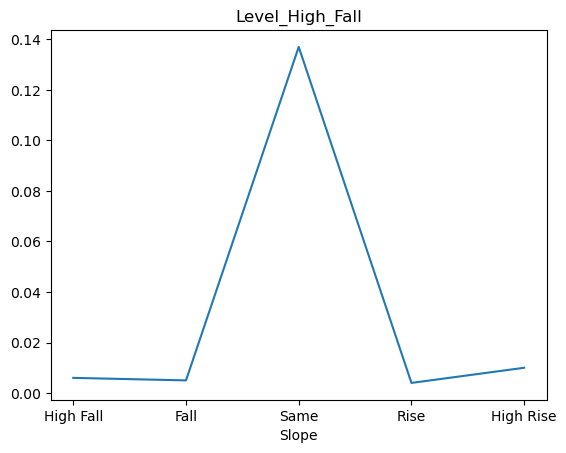

In [988]:
plt.plot(churn_pivot.loc['High Fall',])
plt.xlabel('Slope')
plt.title('Level_High_Fall')

Text(0.5, 1.0, 'Level_Fall')

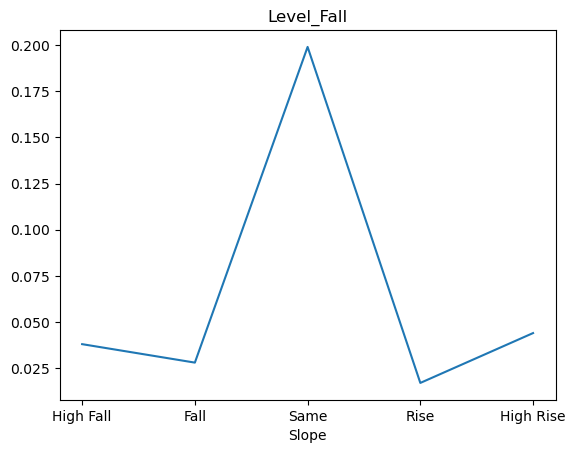

In [987]:
plt.plot(churn_pivot.loc['Fall',])
plt.xlabel('Slope')
plt.title('Level_Fall')

Text(0.5, 1.0, 'Level_Same')

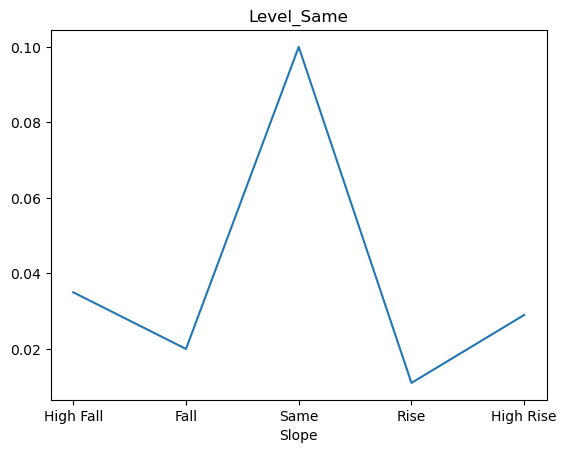

In [989]:
plt.plot(churn_pivot.loc['Same',])
plt.xlabel('Slope')
plt.title('Level_Same')

In [991]:
df_2.rename

,cluster,Level,Slope,Mar_2022,Apr_2022,May_2022,Jun_2022,Jul_2022,Aug_2022,Sep_2022,Oct_2022,Nov_2022,Dec_2022,total
0,0,High Fall,High Fall,183.133333,101.090909,129.700000,127.090909,176.375000,128.312500,190.888889,252.125000,218.882353,170.562500,244.500000
1,1,High Fall,Fall,84.882353,74.666667,77.052632,123.272727,122.076923,105.500000,80.090909,151.956522,125.411765,71.000000,164.166667
2,2,High Fall,Same,71.323529,73.050000,82.823529,79.833333,126.941176,105.166667,76.181818,151.075000,173.342857,129.047619,48.989011
3,3,High Fall,Rise,67.411765,98.272727,91.555556,75.545455,103.181818,80.625000,106.400000,73.583333,209.444444,225.857143,75.600000
4,4,High Fall,High Rise,90.129771,73.493976,76.662500,87.479167,80.914894,87.434211,82.534653,116.451613,111.315385,121.764331,212.000000
5,5,Fall,High Fall,99.000000,135.087912,127.141935,146.232877,183.402299,156.000000,168.814815,222.400000,112.758621,145.166667,146.220000
6,6,Fall,Fall,102.974790,134.581395,160.229299,95.472973,170.794393,210.385185,231.096386,291.381443,175.314103,123.145161,64.540541
7,7,Fall,Same,182.867925,171.937870,158.405063,202.713592,174.184502,207.368966,290.106157,281.539648,333.101732,284.664544,34.136364
8,8,Fall,Rise,131.607143,159.474453,131.859813,230.957265,184.327273,124.360465,241.564767,210.637931,284.492683,359.675781,105.272727
9,9,Fall,High Rise,106.567127,87.292880,85.682990,108.444062,104.908397,99.010899,122.821747,138.189453,160.276490,169.176271,83.672414


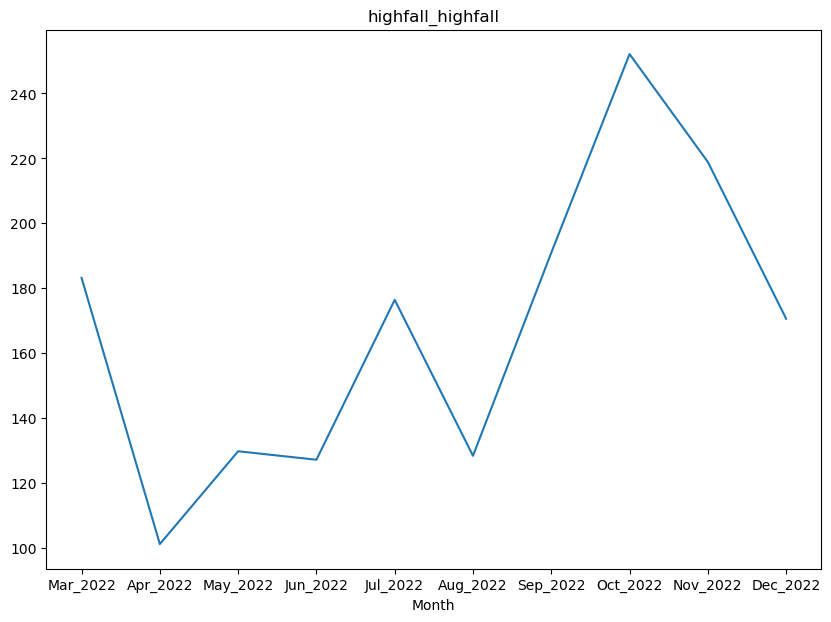

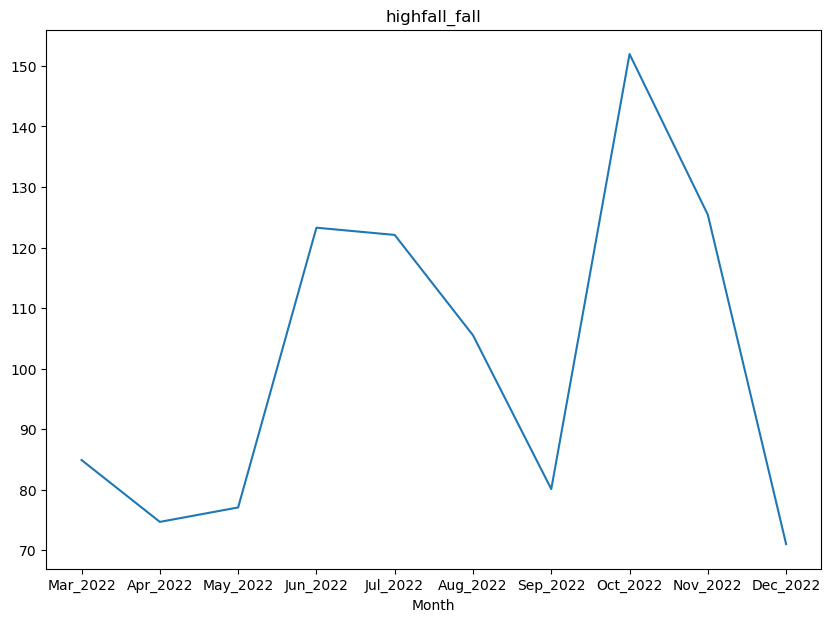

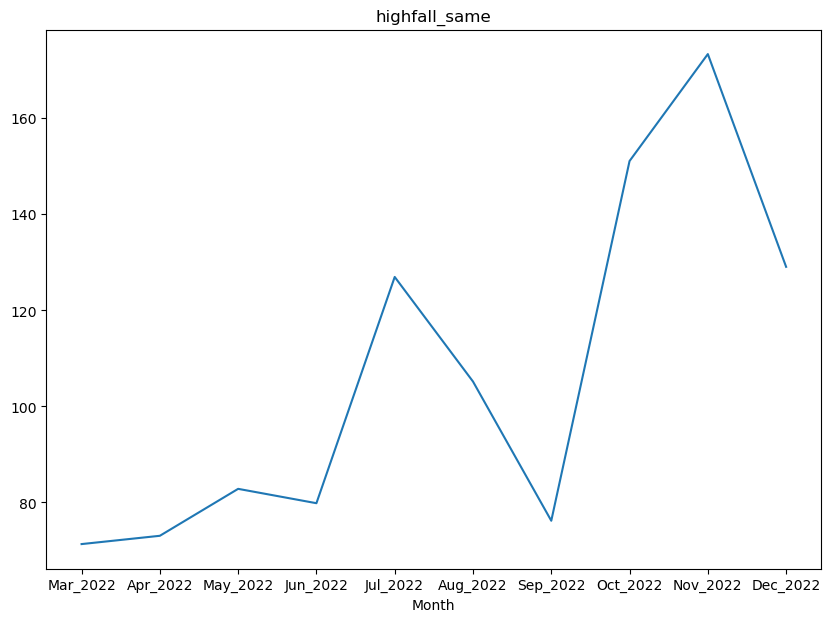

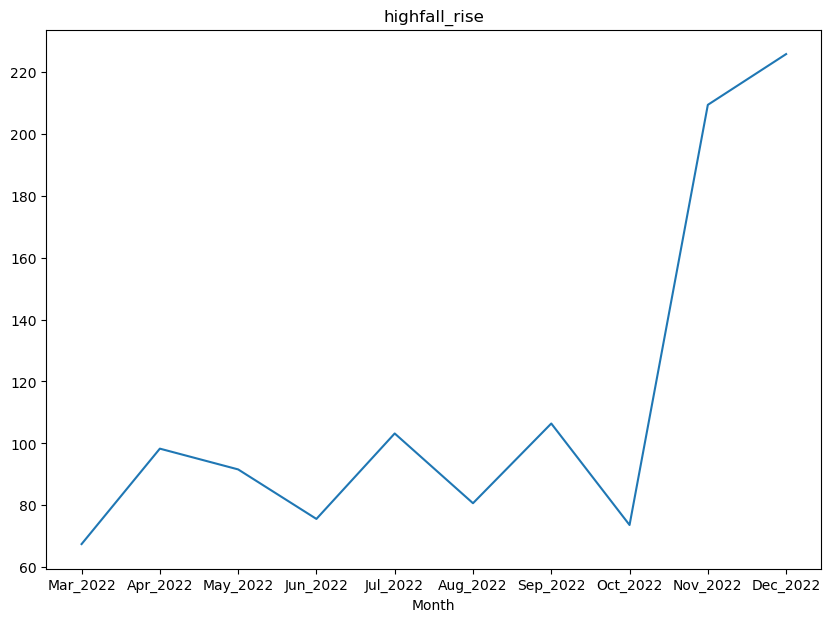

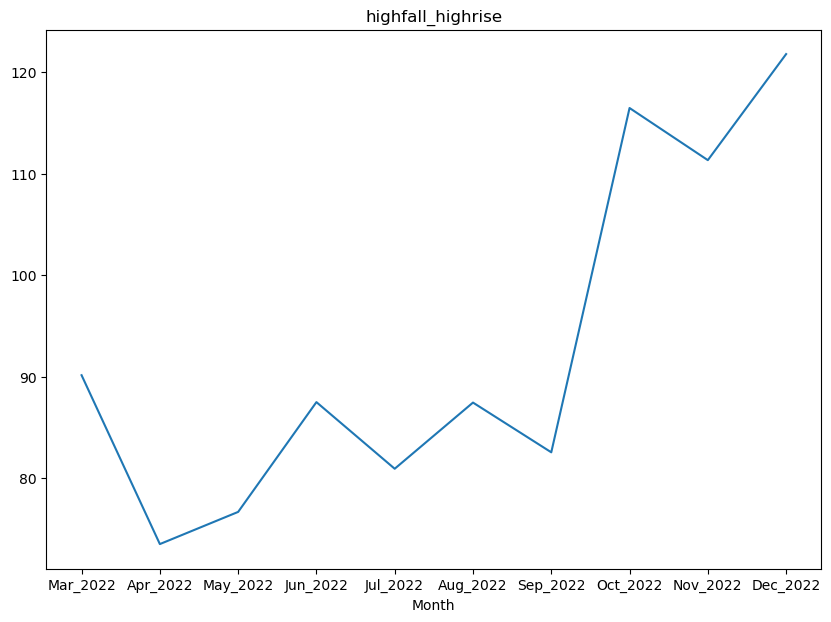

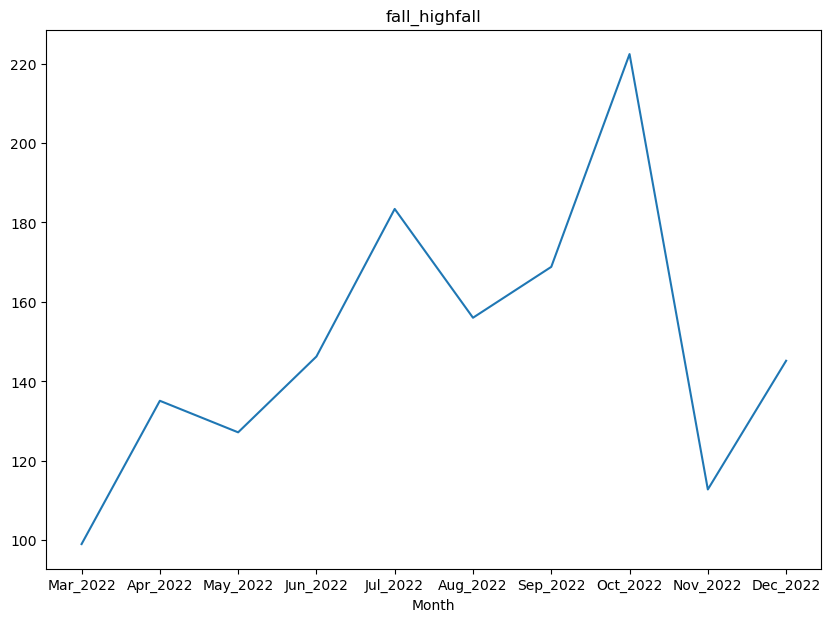

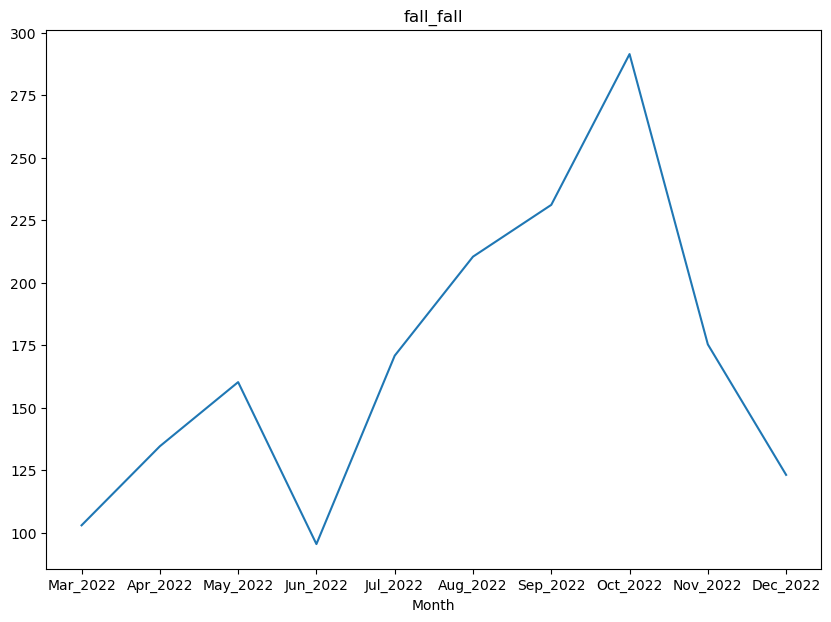

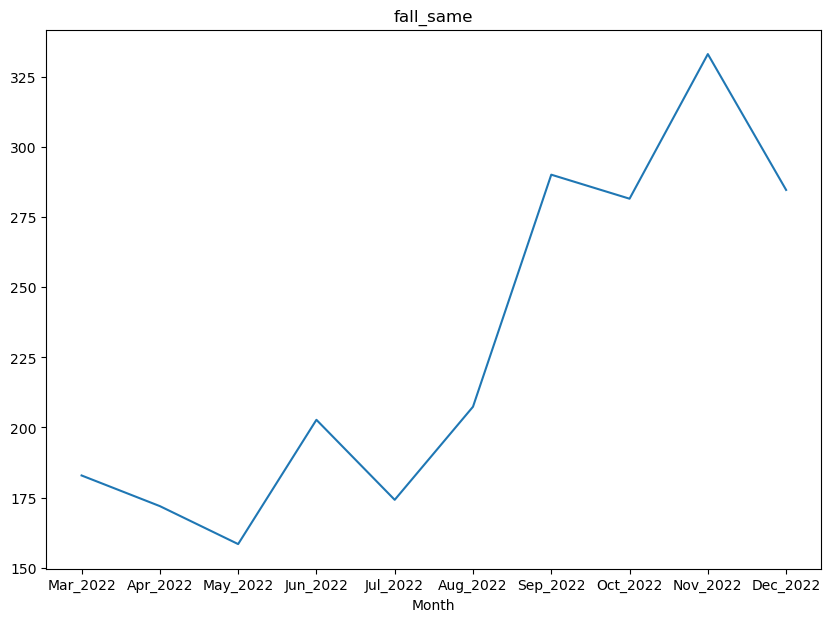

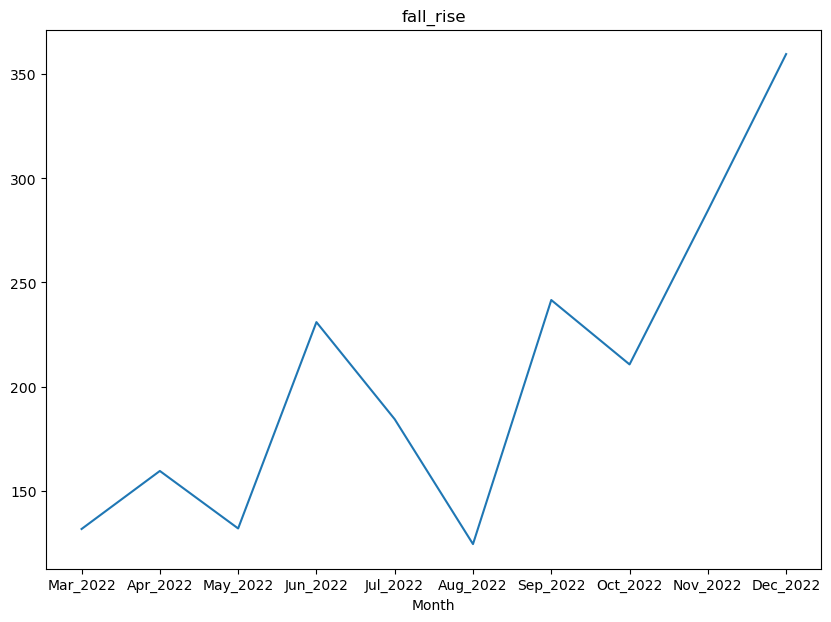

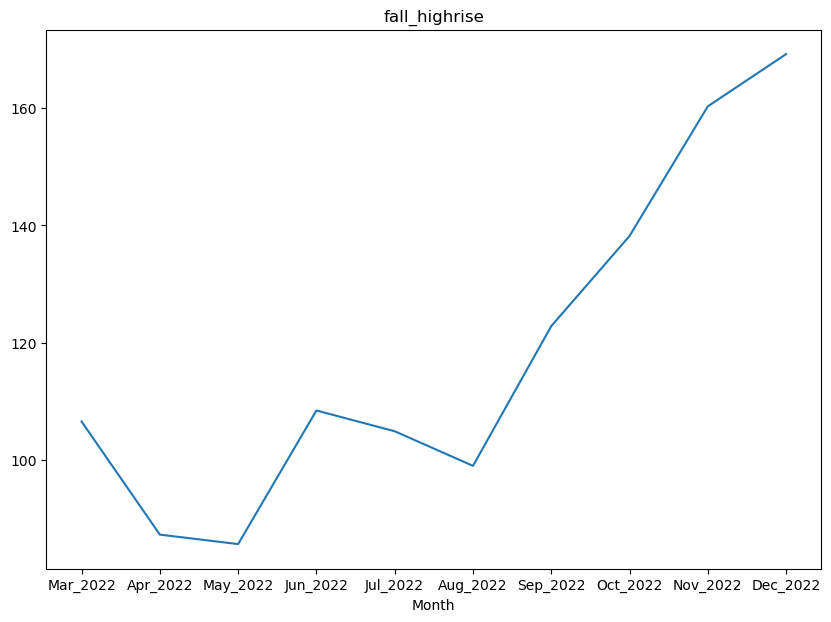

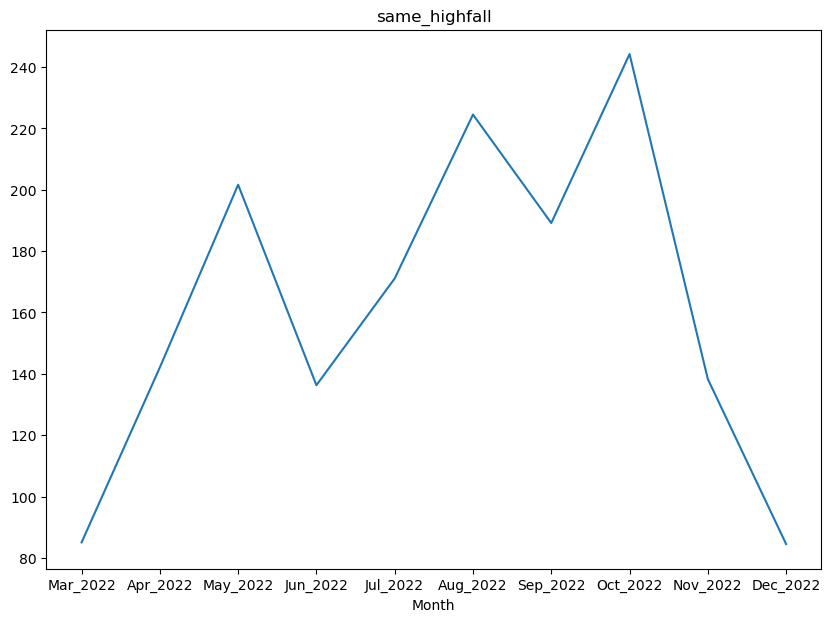

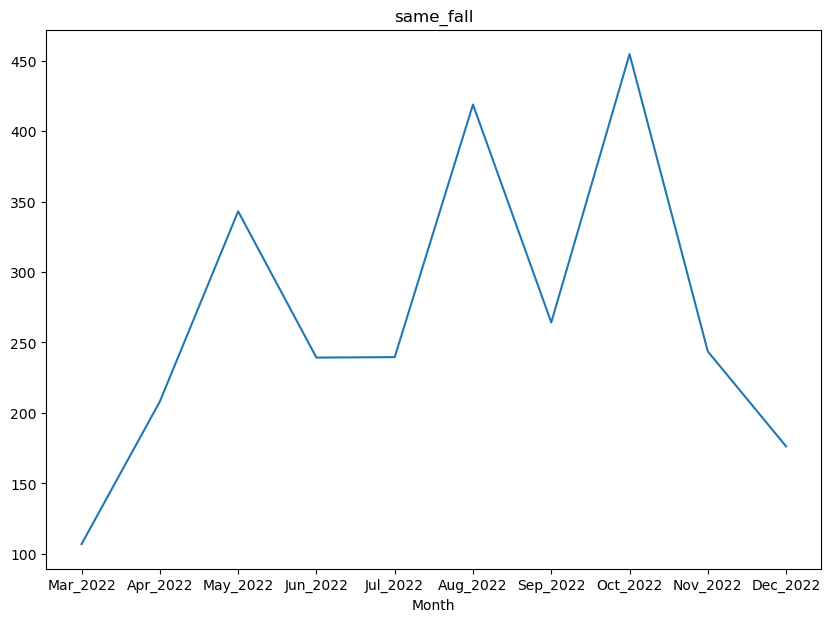

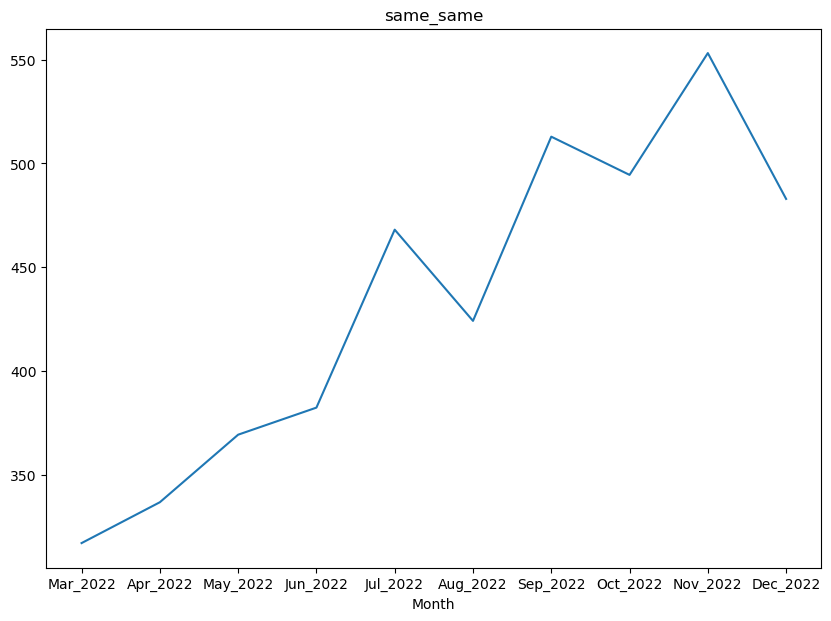

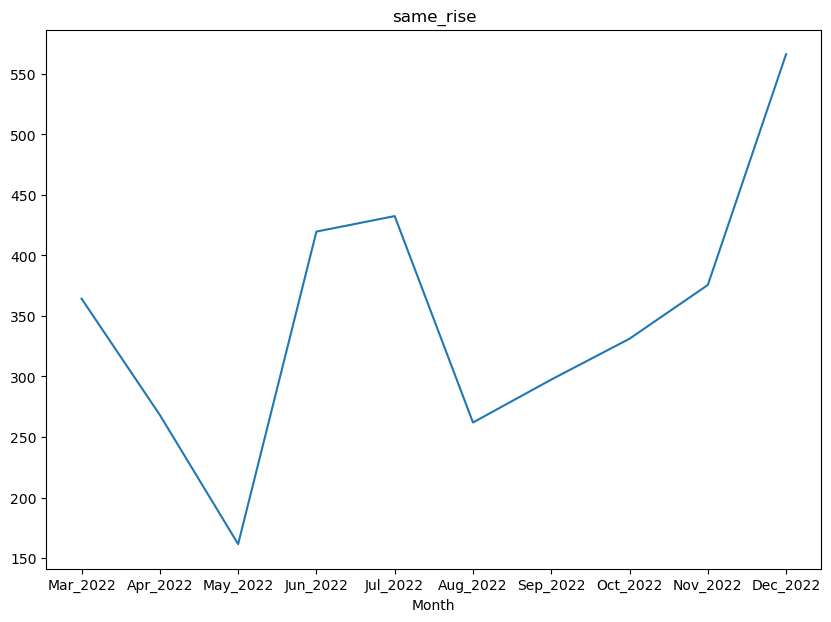

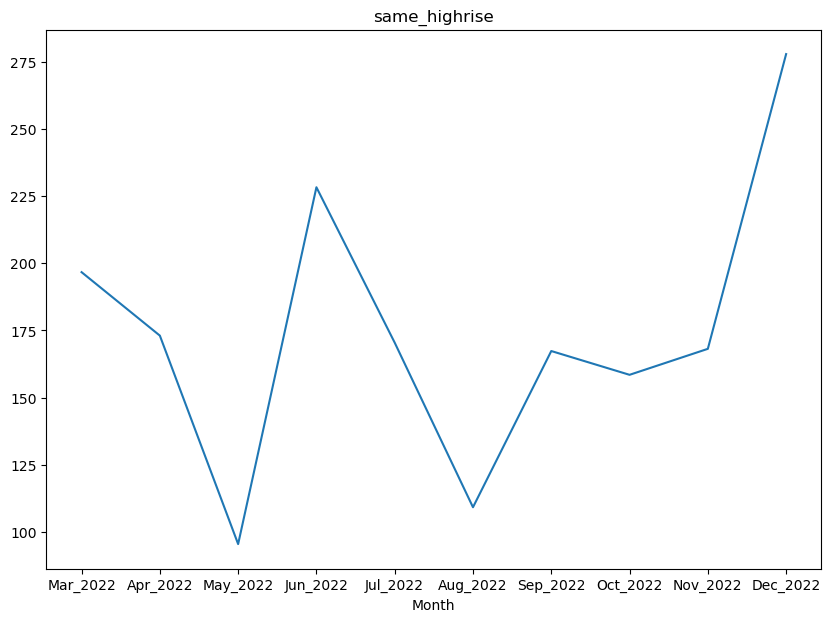

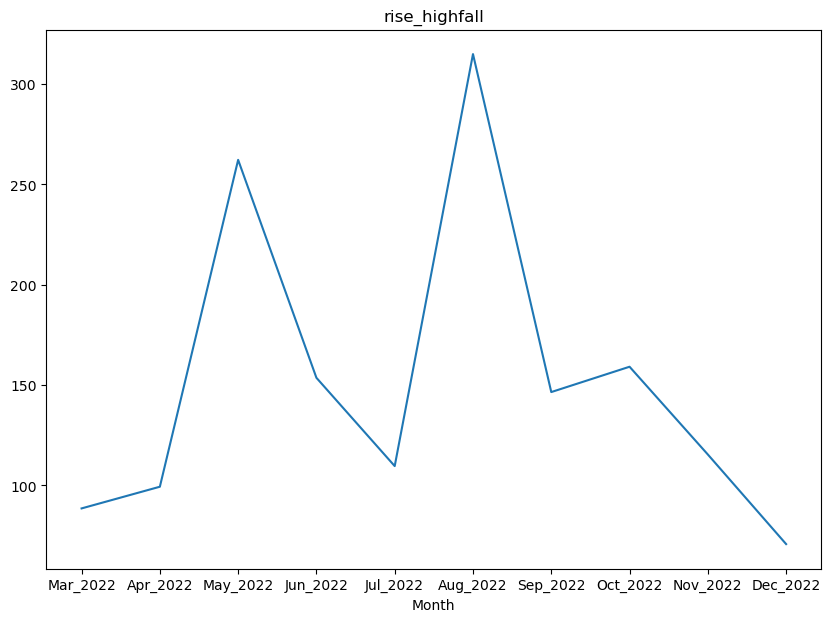

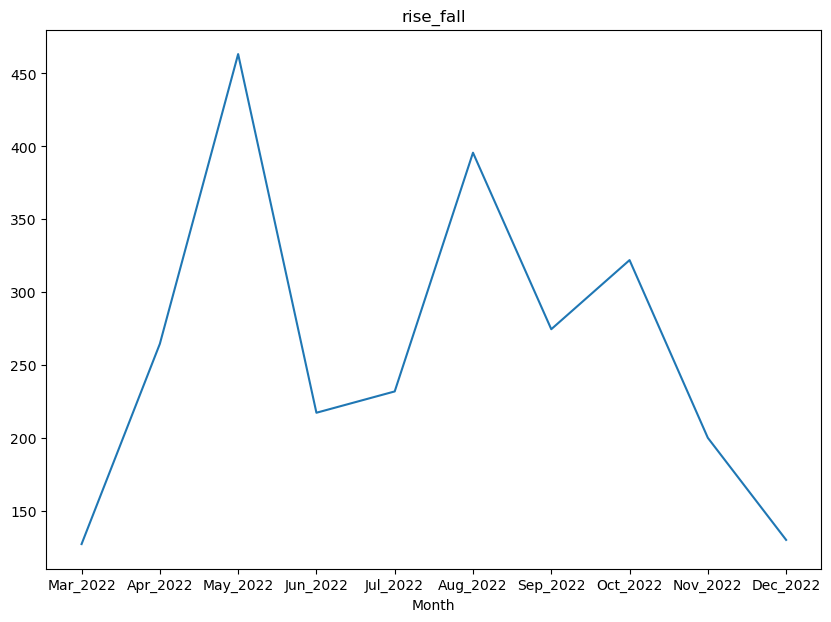

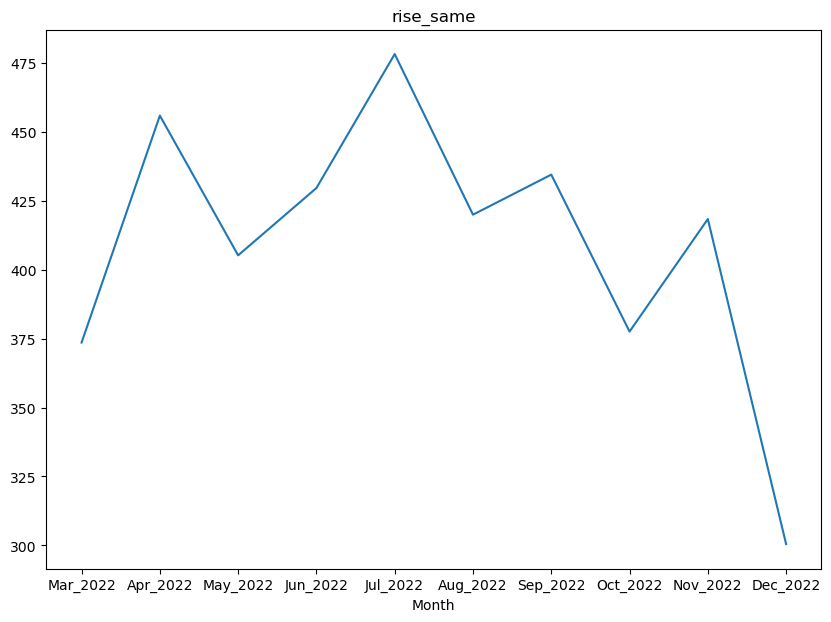

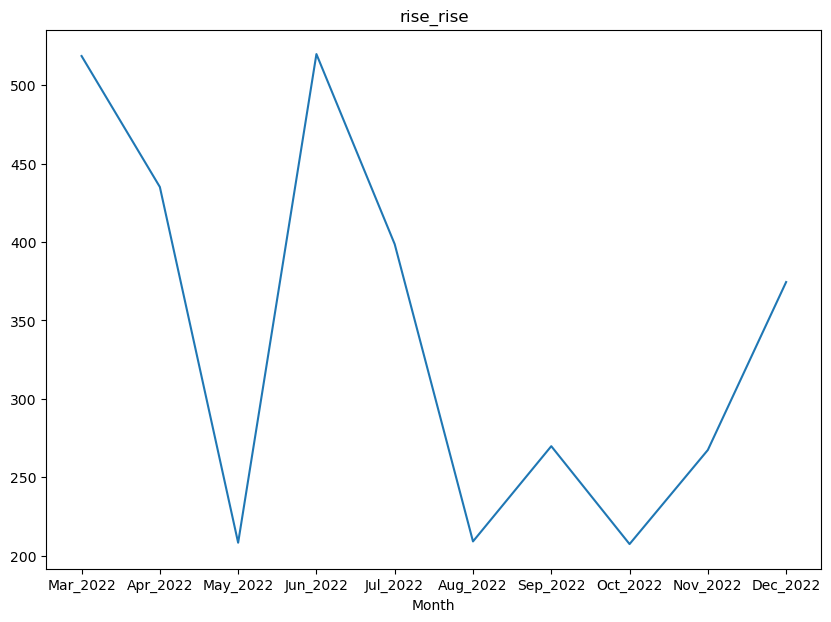

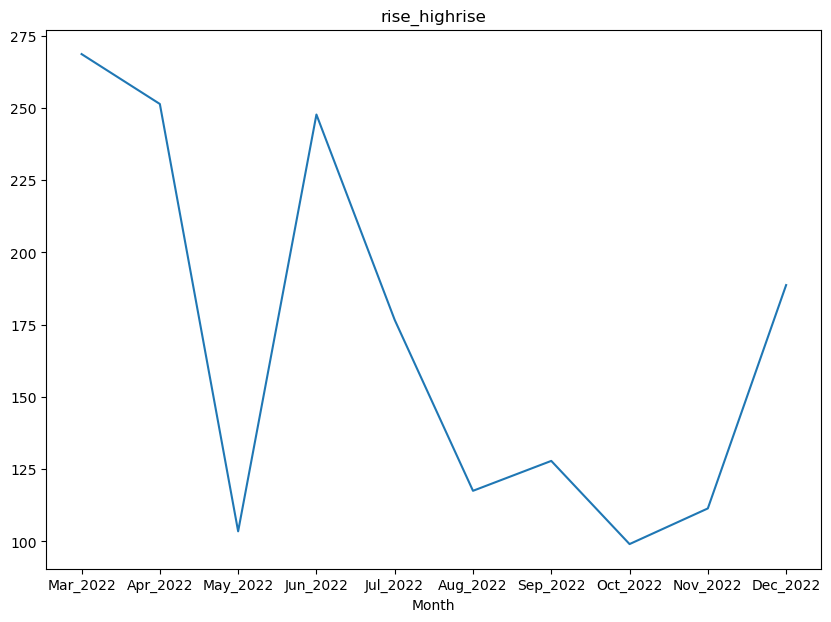

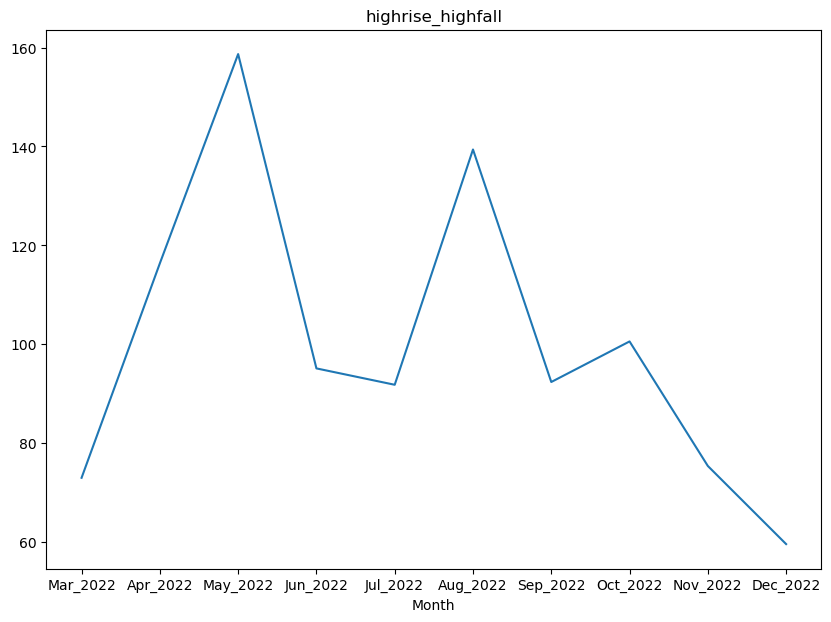

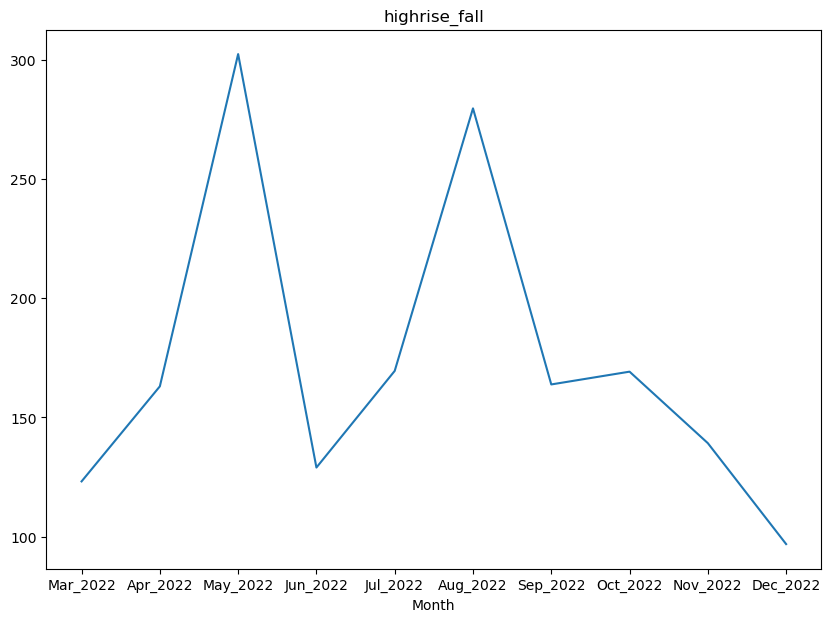

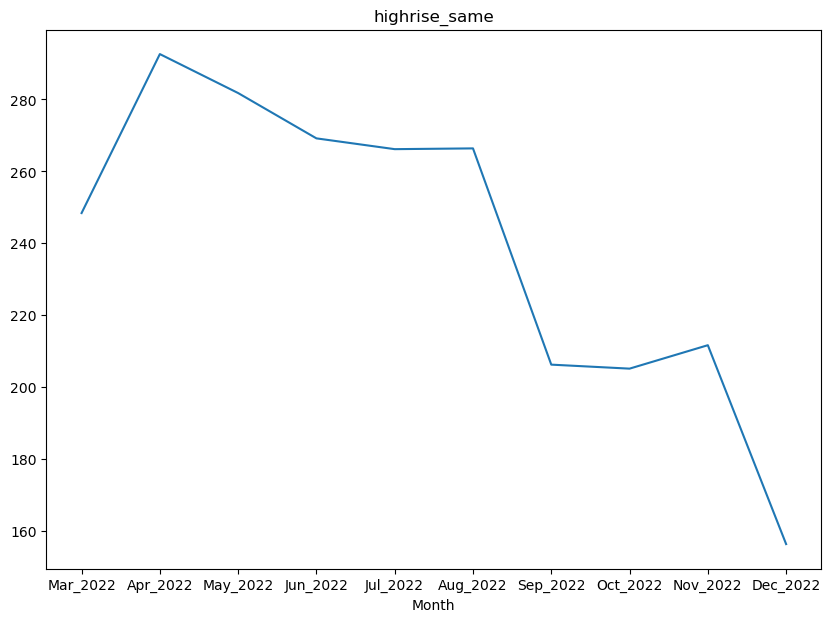

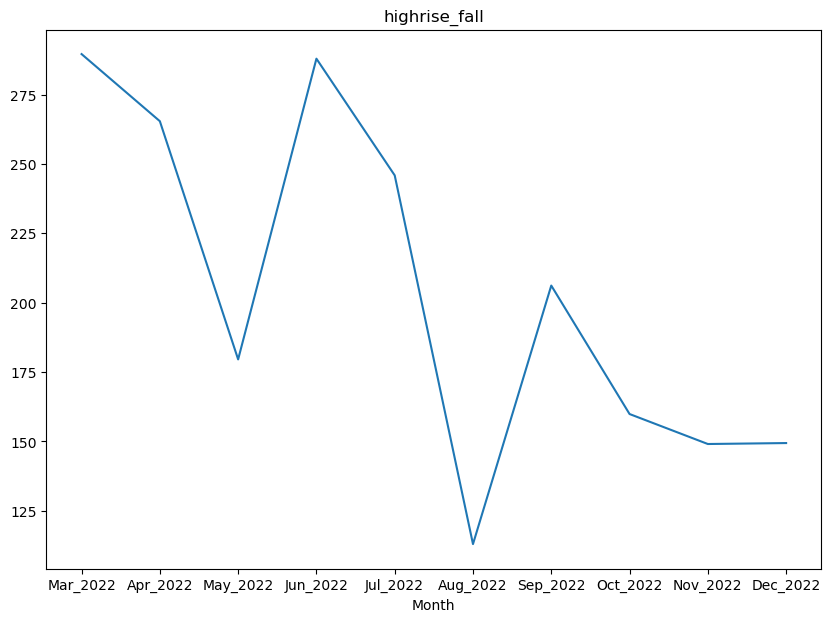

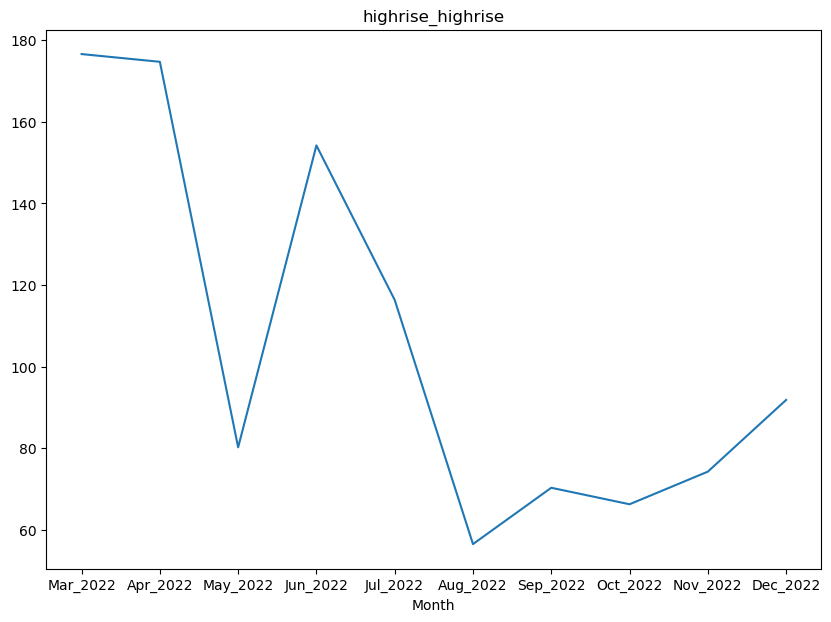

In [1004]:
dict_1 = {0:'highfall_highfall',1:'highfall_fall', 2:'highfall_same',3:'highfall_rise',4:'highfall_highrise',5:'fall_highfall',
         6:'fall_fall',7:'fall_same',8:'fall_rise',9:'fall_highrise',10:'same_highfall',11:'same_fall',
         12:'same_same',13:'same_rise',14:'same_highrise',15:'rise_highfall',16:'rise_fall',17:'rise_same',18:'rise_rise',19:'rise_highrise',
         20:'highrise_highfall',21:'highrise_fall',22:'highrise_same',23:'highrise_fall',24:'highrise_highrise'}
for i in df_2.index:
    fig , ax = plt.subplots(figsize = (10,7))
    plt.plot(df_2.iloc[i,3:13])
    plt.xlabel('Month')
    plt.title(dict_1[i])
    plt.savefig('Figure_1/'+dict_1[i]+'.png')